# Analysis of Rocket League Replay Metrics : Machine Learning Classification and “Game Performance” Equation
### Andrew J. Otis

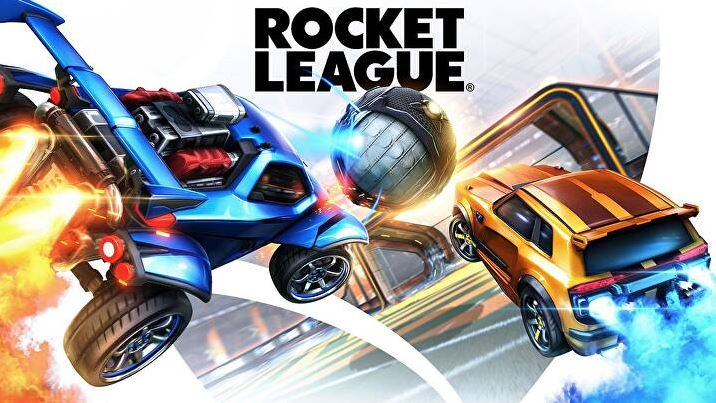

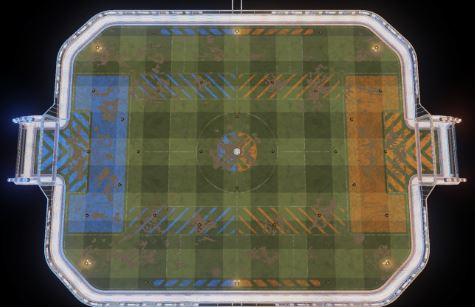

In [2]:
from IPython.display import Image, display
from IPython.display import YouTubeVideo

''' The following function will allow for .jpg images to be placed into the 
jupyter notebook'''
def place_image(pic_name):
    image_path = pic_name
    image = Image(filename=image_path)
    display(image)

place_image("front_cover.jpg")
place_image("playing_field.jpg")


In [3]:
# Recommended module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import requests
from bs4 import BeautifulSoup


In [7]:
# Run the following install code in order to access the module ballchasing, 
#  if necessary
            # pip install python-ballchasing <-- run in terminal
import ballchasing

In [4]:
# Change working directory to utilize relative file paths
import os

# Change the working directory to a new directory
os.chdir('C:/Users/andio/OneDrive/Desktop/PythonProjectsDU/COMP4448_DS_Tools_II/Final_Project/')

# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: C:\Users\andio\OneDrive\Desktop\PythonProjectsDU\COMP4448_DS_Tools_II\Final_Project


## ---------Web Scraping---------

In [8]:
# Initialize the API with the key attained via the instructions from from the 
#  "Documentation" portion of the "References" section
api = ballchasing.Api("4cuopOUxYPSc9LFwmlFFSDfLysN18HmRwf2JYb8o")


### Scraping A Game's Replay Metrics

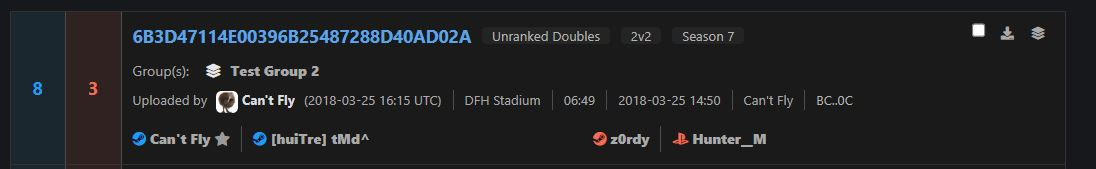

When browsing the webpage, we can click on the hyperlink to see the webaddress of the chosen replay metrics


In [14]:
place_image("single_replay_link_on_page.jpg")

print("When browsing the webpage, we can click on the hyperlink to see the web" \
      "address of the chosen replay metrics")


In [15]:
place_image("single_replay_link.jpg")

print("Important Note: Notice, the highlighted portion in the provided image is what" \
      "the api calls upon, not the entire web address.")


Important Note: Notice, the highlighted portion in the provided image is whatthe api calls upon, not the entire web address.


In [23]:
replay = api.get_replay("52a56379-b02b-4344-90da-9d1dec37a1e8")

# flatten the list of dictionaries with pd.json_normalize()
single_replay_data = pd.json_normalize(replay)

print("Notice, a row is representative of a game. Hence the shape of the data being " \
      "1 row x 128 columns.\n" \
      "\n" \
      "While replay data is generated, it would not be a productive use of time to " \
      "click on every single replay link, then copy and paste the desired portion " \
      "of the link. This will be addressed further in the report.")

print(single_replay_data)


Notice, a row is representative of a game. Hence the shape of the data being 1 row x 128 columns.

While replay data is generated, it would not be a productive use of time to click on every single replay link, then copy and paste the desired portion of the link. This will be addressed further in the report.
                                     id  \
0  52a56379-b02b-4344-90da-9d1dec37a1e8   

                                                link  \
0  https://ballchasing.com/api/replays/52a56379-b...   

                       created status                  rocket_league_id  \
0  2022-11-10T20:16:59.555145Z     ok  A9BFE04A4D77F9C21338169A87E69C90   

                         match_guid  \
0  8FCFFD9C11ED6133C119828F3ADD6B5C   

                                           title   map_code match_type  \
0  2022-11-10.20.16 Big Hack n Fries Private Win  stadium_p    Private   

   team_size  ... orange.stats.movement.count_powerslide  \
0          3  ...                                   

### Scraping Replay Metrics from Multiple Games

While the task of datamining replay data is accomlished, we need data frin lots of games, and it would not be a productive use of time to click on every single replay link with the scraping method previously shown.

A visual of looking at multiple links when browsing the data's source site.


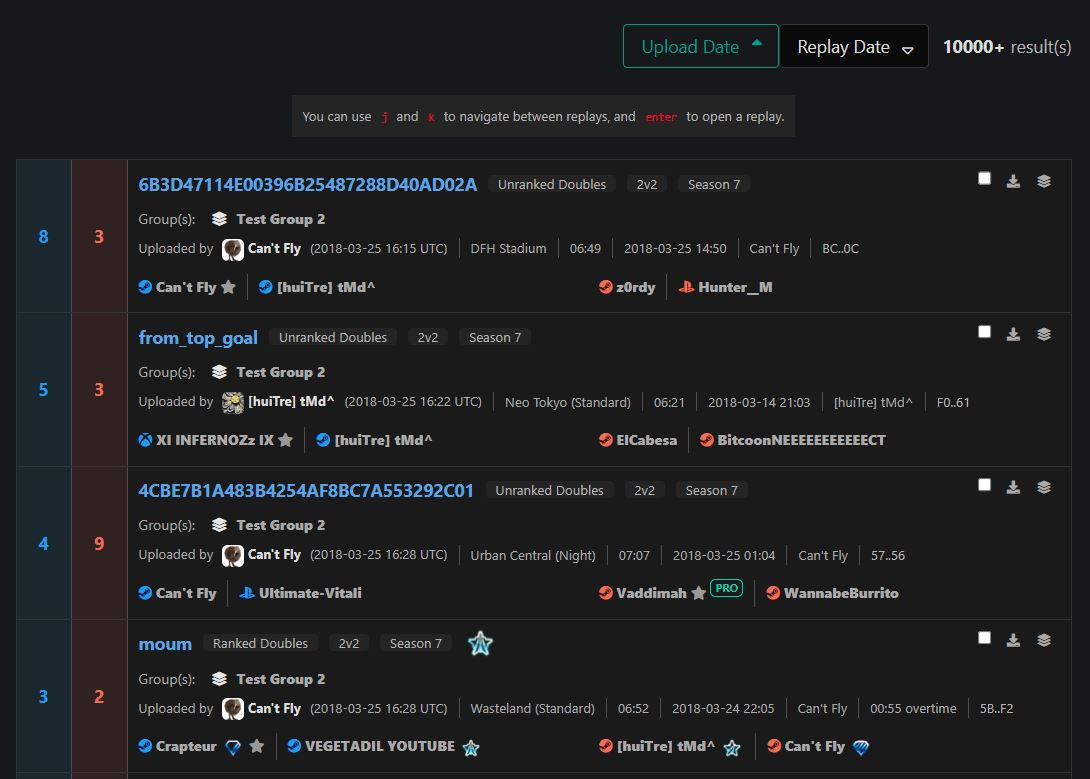

In [24]:
print("A visual of looking at multiple links when browsing the data's source site.") 

place_image('replay_links_on_page.jpg')


In [25]:
'''
The following function returns all HTML info on all the hyperlinks
present on the homepage
'''
def get_href():
    # define the starting URL
    start_url = "https://ballchasing.com/"
    
    # send an HTTP GET request to the starting URL
    response = requests.get(start_url)
    
    # parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")
    
    # find all links in the HTML content
    hyperlinks = soup.find_all("a")
    
    # loop through the hyperlinks and perform any desired actions
    for hyperlink in hyperlinks:
        link_url = hyperlink.get("href")
        print(link_url)
        
        return hyperlinks

In [27]:
print("Notice, this isn't exactly what is needed. We don't need information from every " \
      "single link on the page being scraped. The interest is in HTML info associated " \
      "with replay metrics. A modification will need to be made to the function 'get_href' " \
      "to only include href that gives replay data and name the modified function 'get_replay_links'.")
print()

hyperlinks = get_href()
print(hyperlinks)


Notice, this isn't exactly what is needed. We don't need information from every single link on the page being scraped. The interest is in HTML info associated with replay metrics. A modification will need to be made to the function 'get_href' to only include href that gives replay data and name the modified function 'get_replay_links'.

/
[<a class="is-selected navbar-item" href="/">Replays</a>, <a class="navbar-item" href="/groups">
<span class="icon"><i class="fas fa-layer-group"></i></span>
<span>Replay Groups</span>
</a>, <a class="navbar-link" href="#">
<span class="icon"><i class="fas fa-chart-bar"></i></span>
<span>Population Stats</span>
</a>, <a class="navbar-item" href="/population/distribution">
                            Distribution Stats
                        </a>, <a class="navbar-item" href="/population/average">
                            Average Stats
                        </a>, <a class="navbar-link" href="#">
<span class="icon">
<i class="fas fa-question-circl

## ---------Data Pre-Processing---------

### Data Preparation
Since a lot of files are going to be processed, it would be wise to write functions that perfrom transformation needs. 

Additionally, the data being scraped needs to be transformed so datamining code is also included in this portion of the DS workflow.


In [28]:
'''
The following function returns a dataframe of links for api.get_replay() to 
call upon.
'''
def get_replay_links(start_url):
    # send an HTTP GET request to the starting URL
    response = requests.get(start_url)
    
    # parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")
    
    # find all links in the HTML content
    replays = soup.find_all("a")

    replay_links = []
    for hyperlink in replays:
        link_url = hyperlink.get("href")
        if link_url and link_url.startswith("/replay"):
            replay_links.append({"link": link_url})
    
    replays = pd.DataFrame(replay_links)
    
    replays['link'] = replays['link'].str.replace('/replay/', '')
    
    return replays

In [29]:
'''
The following function utilizes the replay links gathered from 
'get_replay_links' to call the replay data from the selected page from
ballchasing.com via hyperlink (i.e. the "start_link")
'''
def call_and_compile(start_link):
    # run previous function to get multiple replay hrefs
    replay_links = get_replay_links(start_link)

    # a list of the links to loop through with API
    replay_links_list = replay_links['link'].tolist()

    # create an empty list to hold the resulting dataframes
    replays_dfs = []
    
    # loop through the links in replay_links_list 
    for link in replay_links_list:
        try:
            # get the replay data for the current link
            replay = api.get_replay(link)
            
            # json_normalize() function can handle nested JSON data and can 
            #  produce a flattened DataFrame.
            replay_df = pd.json_normalize(replay)
            
            # append the dataframe to the list of dataframes
            replays_dfs.append(replay_df)
        
        # the following block of code accounts for links that refused to be
        #  scraped for whatever reason, by skipping it and contiuing the loop
        #  to completion
        except Exception as e:
            print(f"Error occurred with replay link {link}: {e}")
            continue
    
    combined_replay_data = pd.concat(replays_dfs, ignore_index=True)
    
    return combined_replay_data

#### Using Written Functions to Scrape Replay Metrics of Multiple Games
Important note:

The api calls are written as part of the function, allowing us to run the code blow once, just as demonstrated for scraping metrics from a single game.

Additionally, make a copy of the dataframes to avoid the need to re-scrape everytime the dataframe is altered


In [30]:
# Scrape the data, a copy will be made to maintain its original scraped form
replays_data = call_and_compile("https://ballchasing.com/?after=MS41MjIxMTMwMDY0OThlKzEyX2I1NmMxNjBlLTNjZTctNDVkZS05YzhjLTg0YTQ2YTE1MmJlOQ%3D%3D&playlist=12&playlist=13&playlist=10&playlist=11&sort-by=created&sort-dir=asc")


In [97]:
# Create Copy of the first scrape
df = replays_data.copy(deep = True)

# Take a look at data dimensions of scraped data 
print(df.shape)
print(df.head(3))


(150, 137)
                                     id  \
0  d45e7ee7-0a01-4caa-9a4e-bd6ad1b2dfc3   
1  b329af57-c0db-4d52-afa0-06e7aa197b5f   
2  c6ee3baa-51b2-4608-bb73-cb60722a25bb   

                                                link  \
0  https://ballchasing.com/api/replays/d45e7ee7-0...   
1  https://ballchasing.com/api/replays/b329af57-c...   
2  https://ballchasing.com/api/replays/c6ee3baa-5...   

                       created status                  rocket_league_id  \
0   2018-03-26T23:10:14.55821Z     ok  63732A1840D0568BCE50B0954BA30ACC   
1  2018-03-26T23:10:16.054399Z     ok  6379286C4844BEBA2748DBA2B9CB6315   
2  2018-03-26T23:10:20.367217Z     ok  653A9CFD44155D845F370B938375109C   

                         match_guid                             title  \
0  CF25E67411E819A2872D748C57713967  63732A1840D0568BCE50B0954BA30ACC   
1  85B57E0811E7DCF5E1473FBC97E7C31F                            what ?   
2                               NaN                 6-0 with moun 2v2  

#### Identitfy Columns Present that Contain Null Values

In [90]:
'''
The following function checks a datframe to return columns that contain at 
least one nan value and the count of nan's present in their corresponding
column
'''
def nan_vals(df):
    # count the NaN values in each column of the dataframe
    nan_count = df.isna().sum()
    
    # create a variable (i.e. mask) for selecting columns with nan_count 
    #  greater than 0
    mask = nan_count > 0
    
    # use the mask to select only the relevant columns
    cols_with_nans = df.loc[:, mask]
    cols_with_nans = cols_with_nans.isna().sum()
    return cols_with_nans

In [98]:
# Apply the written "nan_vals()" function
nan_cols = nan_vals(df)
print("Columns with null values in first web scrape")
print(nan_cols)


Columns with null values in first web scrape
match_guid            45
max_rank.id           19
max_rank.tier          2
max_rank.division      2
max_rank.name          2
min_rank.id           39
min_rank.tier         21
min_rank.division     21
min_rank.name         21
overtime_seconds     119
dtype: int64


#### Dealing with Null Values Set to 0 

Same principle as with scraping multiple files, we will be pre-processing multiple scrapes. Thus writing functions for the necessary cleaning would be advantageous, since at that point all that is needed is to use pandas to read the file as a CSV which can then be placed as a parameter within said functions.

In [92]:
print("Don't just drop NA values willy-nilly, make sure the data is understood. "
      "For example, the column overtime_seconds isn't out of place by having "
      "them. Not every game will go to overtime. What makes sense here would "
      "be to convert all the nan values in the column to 0.")
print()
print(("Taking a closer look at the team stats, we see that each color has some nan's. "
       "What this likely is teams that did not perform those in-game actions.\n\n"
       "For example, if the data was of soccer games. The rows would "
       "likely have nan for goalies in the column 'shots_on_goal'. So just set "
       "these nan values to zero."))

'''
The following function fills nan values with zeroes of specificed columns
as discussed above
'''
def fill_withzero(df):
    # portion that's assosciated with the overtime column
    if 'overtime_seconds' in df:
        df['overtime_seconds'] = df['overtime_seconds'].fillna(0)
    
    # portion that's assosciated with the ball possesion time column
    if 'blue.stats.ball.possession_time' in df:
        df['blue.stats.ball.possession_time'] = df['blue.stats.ball.possession_time'].fillna(0)
    if 'blue.stats.ball.time_in_side' in df:
        df['blue.stats.ball.time_in_side'] = df['blue.stats.ball.time_in_side'].fillna(0)
    if 'orange.stats.ball.possession_time' in df:
        df['orange.stats.ball.possession_time'] = df['orange.stats.ball.possession_time'].fillna(0)
    if 'orange.stats.ball.time_in_side' in df:
        df['orange.stats.ball.time_in_side'] = df['orange.stats.ball.time_in_side'].fillna(0)

    nan_cols = nan_vals(df)
    
    return nan_cols

Don't just drop NA values willy-nilly, make sure the data is understood. For example, the column overtime_seconds isn't out of place by having them. Not every game will go to overtime. What makes sense here would be to convert all the nan values in the column to 0.

Taking a closer look at the team stats, we see that each color has some nan's. What this likely is teams that did not perform those in-game actions.

For example, if the data was of soccer games. The rows would likely have nan for goalies in the column 'shots_on_goal'. So just set these nan values to zero.


In [99]:
# Apply the written "fill_withzero()" function
nan_cols = fill_withzero(df)


#### Dropping Rows with null values

In [102]:
def drop_nan_rows(df):
    # drop ALL rows (i.e., replay metrics of a game) with null values
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [103]:
# Apply the written "drop_nan_rows()" function
df = drop_nan_rows(df)
nan_vals(df) 
print(df.head(3))


                                      id  \
0   b329af57-c0db-4d52-afa0-06e7aa197b5f   
1   6458abca-ee61-4053-b918-e3a13e4a9b10   
2   dae093e0-085f-4df2-9704-ab46e43401ef   
3   a2955daf-9998-4989-b40b-1dfc186b2845   
4   2463c0a3-40cb-44f5-9e40-dd575801bcfd   
..                                   ...   
82  f19aa4c5-89ab-43b6-9e0b-ffc1a03ad3e8   
83  d7ec97ff-5fb8-44b8-abd1-8fb0023b11cd   
84  4357a6be-5242-4bf1-8c6a-296a838b7cce   
85  fad30ae9-272d-400c-9efd-d868bff242bc   
86  cc64f9bb-f4bf-4425-9e95-5b6085350eee   

                                                 link  \
0   https://ballchasing.com/api/replays/b329af57-c...   
1   https://ballchasing.com/api/replays/6458abca-e...   
2   https://ballchasing.com/api/replays/dae093e0-0...   
3   https://ballchasing.com/api/replays/a2955daf-9...   
4   https://ballchasing.com/api/replays/2463c0a3-4...   
..                                                ...   
82  https://ballchasing.com/api/replays/f19aa4c5-8...   
83  https://bal

In [51]:
column_names = df.columns.tolist()
print(column_names)


['id', 'link', 'created', 'status', 'rocket_league_id', 'match_guid', 'title', 'recorder', 'map_code', 'match_type', 'team_size', 'playlist_id', 'duration', 'overtime', 'season', 'date', 'date_has_timezone', 'visibility', 'playlist_name', 'map_name', 'uploader.steam_id', 'uploader.name', 'uploader.profile_url', 'uploader.avatar', 'max_rank.id', 'max_rank.tier', 'max_rank.division', 'max_rank.name', 'blue.color', 'blue.players', 'blue.stats.ball.possession_time', 'blue.stats.ball.time_in_side', 'blue.stats.core.shots', 'blue.stats.core.shots_against', 'blue.stats.core.goals', 'blue.stats.core.goals_against', 'blue.stats.core.saves', 'blue.stats.core.assists', 'blue.stats.core.score', 'blue.stats.core.shooting_percentage', 'blue.stats.boost.bpm', 'blue.stats.boost.bcpm', 'blue.stats.boost.avg_amount', 'blue.stats.boost.amount_collected', 'blue.stats.boost.amount_stolen', 'blue.stats.boost.amount_collected_big', 'blue.stats.boost.amount_stolen_big', 'blue.stats.boost.amount_collected_smal

#### Save the cleaned up data if time does not permit more webscraping

In [129]:
# df.to_csv('web_scrape.csv', index=False) <---- only needs to be ran once


#### Gathering More Data, If necessary
If more data is desired, one can simply make another call using the api in this report. Depending on analysis, this may be necessary as the API limits the amount of games to be scraped to 150 games.

In [116]:
# Utilize the api to webscrape more data
replays_data2 = call_and_compile("https://ballchasing.com/?playlist=13")


In [117]:
# Create Copy of the second scrape
df2 = replays_data2.copy(deep = True)

# Preview of webScrape
print(df2.shape)
print(df2)


(150, 137)
                                       id  \
0    0112885e-3aa2-4848-b231-6f62e4f2b446   
1    bf5ebcc1-f913-4239-85ec-2215a133b31e   
2    56abacd6-10ec-4243-9018-a045da232155   
3    7e0bf8f0-0ff0-4488-97d0-d4629d9bb5f8   
4    109cde27-508a-4b88-b29d-946b48f63fa9   
..                                    ...   
145  7e834311-c6e3-4547-9ff5-7ae04f2cc329   
146  e7b0577c-4d4a-4ea2-b5fd-e9103000eeb6   
147  fdbe231d-456a-4106-83f5-40bd99cd114b   
148  b4e59f08-c9d8-413f-ad3e-5d110b7a46bd   
149  0a6a33aa-e995-4263-b6bc-dc0fe940eee1   

                                                  link  \
0    https://ballchasing.com/api/replays/0112885e-3...   
1    https://ballchasing.com/api/replays/bf5ebcc1-f...   
2    https://ballchasing.com/api/replays/56abacd6-1...   
3    https://ballchasing.com/api/replays/7e0bf8f0-0...   
4    https://ballchasing.com/api/replays/109cde27-5...   
..                                                 ...   
145  https://ballchasing.com/api/replays/7

In [118]:
# Deal with null values
nan_cols2 = nan_vals(df2)
print("Columns with null values in web scrape")
print(nan_cols2)


Columns with null values in web scrape
overtime_seconds     112
map_name              19
min_rank.id            4
min_rank.tier          4
min_rank.division      6
min_rank.name          4
max_rank.division      7
dtype: int64


In [119]:
# Dealing with nulls set to 0
nan_cols2 = fill_withzero(df2)

print(df2)


                                       id  \
0    0112885e-3aa2-4848-b231-6f62e4f2b446   
1    bf5ebcc1-f913-4239-85ec-2215a133b31e   
2    56abacd6-10ec-4243-9018-a045da232155   
3    7e0bf8f0-0ff0-4488-97d0-d4629d9bb5f8   
4    109cde27-508a-4b88-b29d-946b48f63fa9   
..                                    ...   
145  7e834311-c6e3-4547-9ff5-7ae04f2cc329   
146  e7b0577c-4d4a-4ea2-b5fd-e9103000eeb6   
147  fdbe231d-456a-4106-83f5-40bd99cd114b   
148  b4e59f08-c9d8-413f-ad3e-5d110b7a46bd   
149  0a6a33aa-e995-4263-b6bc-dc0fe940eee1   

                                                  link  \
0    https://ballchasing.com/api/replays/0112885e-3...   
1    https://ballchasing.com/api/replays/bf5ebcc1-f...   
2    https://ballchasing.com/api/replays/56abacd6-1...   
3    https://ballchasing.com/api/replays/7e0bf8f0-0...   
4    https://ballchasing.com/api/replays/109cde27-5...   
..                                                 ...   
145  https://ballchasing.com/api/replays/7e834311-c..

In [120]:
# Dropping rows with null values
df2 = drop_nan_rows(df2)
nan_vals(df2)
print(df2.shape)
print(df2)


(123, 137)
                                       id  \
0    0112885e-3aa2-4848-b231-6f62e4f2b446   
1    bf5ebcc1-f913-4239-85ec-2215a133b31e   
2    56abacd6-10ec-4243-9018-a045da232155   
3    7e0bf8f0-0ff0-4488-97d0-d4629d9bb5f8   
4    109cde27-508a-4b88-b29d-946b48f63fa9   
..                                    ...   
118  7e834311-c6e3-4547-9ff5-7ae04f2cc329   
119  e7b0577c-4d4a-4ea2-b5fd-e9103000eeb6   
120  fdbe231d-456a-4106-83f5-40bd99cd114b   
121  b4e59f08-c9d8-413f-ad3e-5d110b7a46bd   
122  0a6a33aa-e995-4263-b6bc-dc0fe940eee1   

                                                  link  \
0    https://ballchasing.com/api/replays/0112885e-3...   
1    https://ballchasing.com/api/replays/bf5ebcc1-f...   
2    https://ballchasing.com/api/replays/56abacd6-1...   
3    https://ballchasing.com/api/replays/7e0bf8f0-0...   
4    https://ballchasing.com/api/replays/109cde27-5...   
..                                                 ...   
118  https://ballchasing.com/api/replays/7

In [130]:
# Display present column names
column_names2 = df2.columns.tolist()
print(column_names2)

# Save the cleaned webscrape
#df2.to_csv('web_scrape2.csv', index=False)

['id', 'link', 'created', 'status', 'rocket_league_id', 'match_guid', 'title', 'map_code', 'match_type', 'team_size', 'playlist_id', 'duration', 'overtime', 'overtime_seconds', 'season', 'date', 'date_has_timezone', 'visibility', 'playlist_name', 'map_name', 'uploader.steam_id', 'uploader.name', 'uploader.profile_url', 'uploader.avatar', 'min_rank.id', 'min_rank.tier', 'min_rank.division', 'min_rank.name', 'max_rank.id', 'max_rank.tier', 'max_rank.division', 'max_rank.name', 'blue.color', 'blue.players', 'blue.stats.ball.possession_time', 'blue.stats.ball.time_in_side', 'blue.stats.core.shots', 'blue.stats.core.shots_against', 'blue.stats.core.goals', 'blue.stats.core.goals_against', 'blue.stats.core.saves', 'blue.stats.core.assists', 'blue.stats.core.score', 'blue.stats.core.shooting_percentage', 'blue.stats.boost.bpm', 'blue.stats.boost.bcpm', 'blue.stats.boost.avg_amount', 'blue.stats.boost.amount_collected', 'blue.stats.boost.amount_stolen', 'blue.stats.boost.amount_collected_big',

#### Handling Column differences
To make combining web scraped dataframes as well as later analysis and model building easier, ensure that the columns are matching in name and dimensions when concatenating them vertically.

In [123]:
'''
The following function identifies columns present in one web scrape vs another.
After identifying the mismatching column(s), they are then removed from the 
offending dataframe
'''
def remove_columns_diff(scrape1, scrape2):
    diff1 = set(scrape1.columns) - set(scrape2.columns)
        
    diff2 = set(scrape2.columns) - set(scrape1.columns)
        
    # Remove differing columns from the respective DataFrames
    scrape1.drop(diff1, axis=1, inplace=True)
    scrape2.drop(diff2, axis=1, inplace=True)
    
    return scrape1, scrape2

In [124]:
# Apply the written "remove_columns_diff()" function
remove_columns_diff(df,df2)


(                                      id  \
 0   b329af57-c0db-4d52-afa0-06e7aa197b5f   
 1   6458abca-ee61-4053-b918-e3a13e4a9b10   
 2   dae093e0-085f-4df2-9704-ab46e43401ef   
 3   a2955daf-9998-4989-b40b-1dfc186b2845   
 4   2463c0a3-40cb-44f5-9e40-dd575801bcfd   
 ..                                   ...   
 82  f19aa4c5-89ab-43b6-9e0b-ffc1a03ad3e8   
 83  d7ec97ff-5fb8-44b8-abd1-8fb0023b11cd   
 84  4357a6be-5242-4bf1-8c6a-296a838b7cce   
 85  fad30ae9-272d-400c-9efd-d868bff242bc   
 86  cc64f9bb-f4bf-4425-9e95-5b6085350eee   
 
                                                  link  \
 0   https://ballchasing.com/api/replays/b329af57-c...   
 1   https://ballchasing.com/api/replays/6458abca-e...   
 2   https://ballchasing.com/api/replays/dae093e0-0...   
 3   https://ballchasing.com/api/replays/a2955daf-9...   
 4   https://ballchasing.com/api/replays/2463c0a3-4...   
 ..                                                ...   
 82  https://ballchasing.com/api/replays/f19aa4c5-8.

In [128]:
'''
When the following code is ran again at this point, the columns should match in 
each data set.
'''
# Column(s) in df that are not in df2
diff1 = set(df.columns) - set(df2.columns)
print(diff1)
print()
# Column(s) in df2 that are not in df
diff2 = set(df2.columns) - set(df.columns)
print(diff2)


set()

set()


#### Combine Cleaned Webscrapes and Save as CSV
If we want more data to work with, the second scrape can be combined with another webscrape performed before. In this case, the one performed at the beginnign report.

In [11]:
# Combine web scraped dataframes and reset the index so that there aren't 
#  repeating index values
replays_df = pd.concat([df, df2]).reset_index(drop=True)

print(replays_df.shape)

print(replays_df.head(3))
#replays_df.to_csv('replays_data.csv' ,index=False) <----only needs to be ran once


(210, 136)
                                     id  \
0  b329af57-c0db-4d52-afa0-06e7aa197b5f   
1  6458abca-ee61-4053-b918-e3a13e4a9b10   
2  dae093e0-085f-4df2-9704-ab46e43401ef   

                                                link  \
0  https://ballchasing.com/api/replays/b329af57-c...   
1  https://ballchasing.com/api/replays/6458abca-e...   
2  https://ballchasing.com/api/replays/dae093e0-0...   

                       created status                  rocket_league_id  \
0  2018-03-26T23:10:16.054399Z     ok  6379286C4844BEBA2748DBA2B9CB6315   
1  2018-03-26T23:10:30.800192Z     ok  6697B4F742A6664AD3B0368665649250   
2  2018-03-26T23:10:40.041701Z     ok  67FFCEF94A9FDF7FFE4457A273F1CFA4   

                         match_guid                             title  \
0  85B57E0811E7DCF5E1473FBC97E7C31F                            what ?   
1  2A0041A811E81EE3D200D188CC9114AB  6697B4F742A6664AD3B0368665649250   
2  636A6A7811E81A6ED40FFD9E1E6114F5  67FFCEF94A9FDF7FFE4457A273F1CFA4  

#### Create a Dataframe of Player Specific Data and Save as CSV

In [41]:
# Check to see which columns are strictly blue team data
blue_columns = replays_df.columns[27:79]
print("---Columns for Players on Blue Team for a Match---")
print(blue_columns)
print()

# Check to see which columns are strictly orange team data
orange_columns = replays_df.columns[79:131]
print("---Columns for Players on Orange Team for a Match---")
print(orange_columns)


---Columns for Players on Blue Team for a Match---
Index(['blue.color', 'blue.players', 'blue.stats.ball.possession_time',
       'blue.stats.ball.time_in_side', 'blue.stats.core.shots',
       'blue.stats.core.shots_against', 'blue.stats.core.goals',
       'blue.stats.core.goals_against', 'blue.stats.core.saves',
       'blue.stats.core.assists', 'blue.stats.core.score',
       'blue.stats.core.shooting_percentage', 'blue.stats.boost.bpm',
       'blue.stats.boost.bcpm', 'blue.stats.boost.avg_amount',
       'blue.stats.boost.amount_collected', 'blue.stats.boost.amount_stolen',
       'blue.stats.boost.amount_collected_big',
       'blue.stats.boost.amount_stolen_big',
       'blue.stats.boost.amount_collected_small',
       'blue.stats.boost.amount_stolen_small',
       'blue.stats.boost.count_collected_big',
       'blue.stats.boost.count_stolen_big',
       'blue.stats.boost.count_collected_small',
       'blue.stats.boost.count_stolen_small',
       'blue.stats.boost.amount_overf

In [45]:
# Create a dataframe of player stats who were on the blue team for a chosen 
#  match[79:131]
blue = replays_df.iloc[:, 27:79]
print(blue.shape)
#blue.to_csv('blue.csv', index=False)

orange = replays_df.iloc[:, 79:131]
print(orange.shape)
# orange.to_csv('orange.csv', index=False)
'''
Important note:
The dimensions are expected to be the same, the "blue" and "orange" datasets
come directly from the main dataset "replays_data"
'''

(210, 52)
(210, 52)


### Load in the data that is to be worked with

If we want more data to work with, the second scrape can be combined with another webscrape performed before. In this case, the one performed at the beginnign report.

In [15]:
print("Important Note: The main dataset and data frames it consists of will be saved." \
      "Allowing one to avoid having to go through the timely scraping process again." \
      "This also assists in the consistency of model construction and thus, our findings")
print()
# Load in the dataframes that make up the dataset once saved so that the
#  combined dataframe remains consistent
df = pd.read_csv('web_scrape.csv')
print(df.shape)
df2 = pd.read_csv('web_scrape2.csv')
print(df2.shape)


Important Note: The main dataset and data frames it consists of will be saved.Allowing one to avoid having to go through the timely scraping process again.This also assists in the consistency of model construction and thus, our findings

(87, 136)
(123, 136)


In [16]:
# Load in the main dataset that will be worked on
replays_df = pd.read_csv('replays_data.csv')


In [273]:
# Load in the data individual matches for each team
blue_team = pd.read_csv('blue.csv')

orange_team = pd.read_csv('orange.csv')


### Exploratory Data Analysis

In [26]:
# General info
print("---General Info on Rocket League Replay Metrics---")
print(replays_df.info())
print()

# Dimensions of data
print("---Dimensions of Rocket League Replay Metrics---")
print(replays_df.shape) # just df and df2 combined
print()

# Datatypes present
print("---Datatypes of Rocket League Replay Metrics---")
unique_data_types = replays_df.dtypes.unique()
print(unique_data_types)
print()

# Stats on numeric columns
print("---Descriptive Stats of Rocket League Replay Metrics---")
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
descriptive_stats = numeric_columns.describe()
print(descriptive_stats)


---General Info on Rocket League Replay Metrics---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 136 entries, id to overtime_seconds
dtypes: bool(2), float64(55), int64(54), object(25)
memory usage: 220.4+ KB
None

---Dimensions of Rocket League Replay Metrics---
(210, 136)

---Datatypes of Rocket League Replay Metrics---
[dtype('O') dtype('int64') dtype('bool') dtype('float64')]

---Descriptive Stats of Rocket League Replay Metrics---
       team_size    duration     season  uploader.steam_id  max_rank.tier  \
count       87.0   87.000000  87.000000       8.700000e+01      87.000000   
mean         2.0  346.632184   6.586207       7.656120e+16      14.298851   
std          0.0   65.986453   0.495367       9.655653e+01       0.953756   
min          2.0  161.000000   6.000000       7.656120e+16      13.000000   
25%          2.0  322.000000   6.000000       7.656120e+16      13.000000   
50%          2.0  354.000000   7.000000       7.656120e+16     

In [34]:
print("Notice, the in-game data (e.g. players and what colored team played on) "
      " is a list of lists, respectively. Where the inner list contains "
      "dictionaries. These columns will need to be flattened out if the data is "
      "to be more analysis friendly. This was accomplished in the pre-processing"
      "portion")
print()

# Unique responses from columns with strings as responses
string_columns = replays_df.select_dtypes(include=['object'])
unique_responses = string_columns.apply(lambda x: x.unique())
print(unique_responses)


Notice, the in-game data (e.g. players and what colored team played on)  is a list of lists, respectively. Where the inner list contains dictionaries. These columns will need to be flattened out if the data is to be more analysis friendly. This was accomplished in the pre-processingportion

id                      [b329af57-c0db-4d52-afa0-06e7aa197b5f, 6458abc...
link                    [https://ballchasing.com/api/replays/b329af57-...
created                 [2018-03-26T23:10:16.054399Z, 2018-03-26T23:10...
status                                                               [ok]
rocket_league_id        [6379286C4844BEBA2748DBA2B9CB6315, 6697B4F742A...
match_guid              [85B57E0811E7DCF5E1473FBC97E7C31F, 2A0041A811E...
title                   [what ?, 6697B4F742A6664AD3B0368665649250, 67F...
map_code                [park_night_p, park_p, trainstation_p, trainst...
match_type                                                       [Online]
playlist_id                             [r

#### Indexable Tables on Match Data

In [129]:
blue_team.iloc[:, 1]

blue_team.drop(blue_team.columns[1], axis=1, inplace=True)
print(blue_team)


    color  stats.core.shots  stats.core.shots_against  stats.core.goals  \
0    blue                 7                         9                 2   
1    blue                 4                         8                 1   
2    blue                 6                         5                 4   
3    blue                 5                         2                 1   
4    blue                10                         5                 7   
..    ...               ...                       ...               ...   
205  blue                 2                         7                 0   
206  blue                 9                         9                 1   
207  blue                 6                        13                 3   
208  blue                 8                         4                 5   
209  blue                 6                         4                 3   

     stats.core.goals_against  stats.core.saves  stats.core.assists  \
0                           

In [130]:
orange_team.iloc[:, 1]

orange_team.drop(orange_team.columns[1], axis=1, inplace=True)
print(orange_team)


      color  stats.ball.time_in_side  stats.core.shots  \
0    orange                   195.35                 9   
1    orange                   153.82                 8   
2    orange                   178.24                 5   
3    orange                   157.21                 2   
4    orange                   169.85                 5   
..      ...                      ...               ...   
205  orange                   148.08                 7   
206  orange                   156.07                 9   
207  orange                   123.74                13   
208  orange                   171.88                 4   
209  orange                   201.89                 4   

     stats.core.shots_against  stats.core.goals  stats.core.goals_against  \
0                           7                 3                         2   
1                           4                 5                         1   
2                           6                 5                         

In [441]:
# Make a list for data on the blue team
blue = []
for i in range(len(blue_team)):
    blue_transposed = blue_team.iloc[i:i+1, ~blue_team.columns.isin(['blue.players'])].transpose()
    print(f"blue Team Stats for Game {i+1}:")
    print(blue_team.iloc[i:i+1, ~blue_team.columns.isin(['blue.players'])].transpose())
    blue.append(blue_transposed)

blue_team.columns = blue_team.columns.str.replace('blue.', '')

# Remove 'players' column from blue list
blue = [blue.drop('players', axis=0) for blue in blue]

print(blue)


blue Team Stats for Game 1:
                                                       0
blue.color                                          blue
blue.stats.ball.possession_time                   148.29
blue.stats.ball.time_in_side                      127.46
blue.stats.core.shots                                  7
blue.stats.core.shots_against                          9
blue.stats.core.goals                                  2
blue.stats.core.goals_against                          3
blue.stats.core.saves                                  2
blue.stats.core.assists                                1
blue.stats.core.score                               1010
blue.stats.core.shooting_percentage            28.571428
blue.stats.boost.bpm                                 651
blue.stats.boost.bcpm                           689.0304
blue.stats.boost.avg_amount                       106.72
blue.stats.boost.amount_collected                   3841
blue.stats.boost.amount_stolen                       632
blu

blue.stats.demo.taken                                   0
blue Team Stats for Game 77:
                                                     76
blue.color                                         blue
blue.stats.ball.possession_time                  147.83
blue.stats.ball.time_in_side                     138.16
blue.stats.core.shots                                 5
blue.stats.core.shots_against                         6
blue.stats.core.goals                                 2
blue.stats.core.goals_against                         4
blue.stats.core.saves                                 2
blue.stats.core.assists                               0
blue.stats.core.score                               840
blue.stats.core.shooting_percentage                40.0
blue.stats.boost.bpm                                781
blue.stats.boost.bcpm                          811.0248
blue.stats.boost.avg_amount                       96.91
blue.stats.boost.amount_collected                  4610
blue.stats.boost.

blue.stats.demo.taken                                  5
blue Team Stats for Game 153:
                                                      152
blue.color                                           blue
blue.stats.ball.possession_time                    120.65
blue.stats.ball.time_in_side                       156.96
blue.stats.core.shots                                   7
blue.stats.core.shots_against                           8
blue.stats.core.goals                                   4
blue.stats.core.goals_against                           2
blue.stats.core.saves                                   4
blue.stats.core.assists                                 3
blue.stats.core.score                                1126
blue.stats.core.shooting_percentage             57.142857
blue.stats.boost.bpm                                 1132
blue.stats.boost.bcpm                           1164.0642
blue.stats.boost.avg_amount                        146.18
blue.stats.boost.amount_collected          

C:\Users\andio\AppData\Local\Temp\ipykernel_19856\2537202067.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  blue_team.columns = blue_team.columns.str.replace('blue.', '')


KeyError: "['players'] not found in axis"

In [132]:
# Make a list for data on the orange team
orange = []
for i in range(len(orange_team)):
    orange_transposed = orange_team.iloc[i:i+1, ~orange_team.columns.isin(['orange.players'])].transpose()
    print(f"Orange Team Stats for Game {i+1}:")
    print(orange_team.iloc[i:i+1, ~orange_team.columns.isin(['orange.players'])].transpose())
    orange.append(orange_transposed)
    

orange_team.columns = orange_team.columns.str.replace('orange.', '')
print(orange)


Orange Team Stats for Game 1:
                                                   0
color                                         orange
stats.ball.time_in_side                       195.35
stats.core.shots                                   9
stats.core.shots_against                           7
stats.core.goals                                   3
stats.core.goals_against                           2
stats.core.saves                                   3
stats.core.assists                                 1
stats.core.score                                1220
stats.core.shooting_percentage             33.333332
stats.boost.bpm                                  878
stats.boost.bcpm                            840.4341
stats.boost.avg_amount                        101.26
stats.boost.amount_collected                    4685
stats.boost.amount_stolen                        693
stats.boost.amount_collected_big                3700
stats.boost.amount_stolen_big                    516
stats.boost.amou

stats.demo.taken                                   0
Orange Team Stats for Game 59:
                                                  58
color                                         orange
stats.ball.time_in_side                       173.26
stats.core.shots                                   2
stats.core.shots_against                           5
stats.core.goals                                   2
stats.core.goals_against                           1
stats.core.saves                                   4
stats.core.assists                                 0
stats.core.score                                 910
stats.core.shooting_percentage                 100.0
stats.boost.bpm                                  651
stats.boost.bcpm                           671.21924
stats.boost.avg_amount                        115.49
stats.boost.amount_collected                    3604
stats.boost.amount_stolen                        746
stats.boost.amount_collected_big                2759
stats.boost.amo

stats.demo.taken                                  1
Orange Team Stats for Game 135:
                                                 134
color                                         orange
stats.ball.time_in_side                       206.49
stats.core.shots                                   2
stats.core.shots_against                          11
stats.core.goals                                   1
stats.core.goals_against                           4
stats.core.saves                                   4
stats.core.assists                                 1
stats.core.score                                 783
stats.core.shooting_percentage                  50.0
stats.boost.bpm                                 1039
stats.boost.bcpm                           1031.1826
stats.boost.avg_amount                        135.38
stats.boost.amount_collected                    5743
stats.boost.amount_stolen                        894
stats.boost.amount_collected_big                4285
stats.boost.amo

[                                                   0
color                                         orange
stats.ball.time_in_side                       195.35
stats.core.shots                                   9
stats.core.shots_against                           7
stats.core.goals                                   3
stats.core.goals_against                           2
stats.core.saves                                   3
stats.core.assists                                 1
stats.core.score                                1220
stats.core.shooting_percentage             33.333332
stats.boost.bpm                                  878
stats.boost.bcpm                            840.4341
stats.boost.avg_amount                        101.26
stats.boost.amount_collected                    4685
stats.boost.amount_stolen                        693
stats.boost.amount_collected_big                3700
stats.boost.amount_stolen_big                    516
stats.boost.amount_collected_small           

C:\Users\andio\AppData\Local\Temp\ipykernel_19856\1307140033.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  orange_team.columns = orange_team.columns.str.replace('orange.', '')


In [143]:
combined_list = []

for blue_transposed, orange_transposed in zip(blue, orange):
    combined_data = pd.concat([blue_transposed, orange_transposed], axis=1)
    combined_data.columns = ['blue', 'orange']
    combined_list.append(combined_data)

print("At this point in time, we have a list of tables that can index any game(i.e. row) and look at" 
      " the overall stats or how one team performed against the opposing team.")
print()

# General Match data for the first 5 games(i.e. rows) of the original dataset
print(combined_list[:5]) 


At this point in time, we have a list of tables that can index any game(i.e. row) and look at the overall stats or how one team performed against the opposing team.

[                                               blue      orange
color                                          blue      orange
stats.core.shots                                  7           9
stats.core.shots_against                          9           7
stats.core.goals                                  2           3
stats.core.goals_against                          3           2
stats.core.saves                                  2           3
stats.core.assists                                1           1
stats.core.score                               1010        1220
stats.core.shooting_percentage            28.571428   33.333332
stats.boost.bpm                                 651         878
stats.boost.bcpm                           689.0304    840.4341
stats.boost.avg_amount                       106.72      101.26
s

In [145]:
# Indexing a Game
print("General Stats for Game 1")
team_game_stats = combined_list[0].iloc[:, 0:2]
team_game_stats


General Stats for Game 1


blue      orange
color                                          blue      orange
stats.core.shots                                  7           9
stats.core.shots_against                          9           7
stats.core.goals                                  2           3
stats.core.goals_against                          3           2
stats.core.saves                                  2           3
stats.core.assists                                1           1
stats.core.score                               1010        1220
stats.core.shooting_percentage            28.571428   33.333332
stats.boost.bpm                                 651         878
stats.boost.bcpm                           689.0304    840.4341
stats.boost.avg_amount                       106.72      101.26
stats.boost.amount_collected                   3841        4685
stats.boost.amount_stolen                       632         693
stats.boost.amount_collected_big               3039        3700
stats.boost.amount_stolen_big                   350         516
stats.boost.amount_collected_small              802         985
stats.boost.amount_stolen_small                 282         177
stats.boost.count_collected_big                  37          44
stats.boost.count_stolen_big                      4           6
stats.boost.count_collected_small                70          90
stats.boost.count_stolen_small                   24          17
stats.boost.amount_overfill                     605         670
stats.boost.amount_overfill_stolen               22          82
stats.boost.amount_used_while_supersonic        608         648
stats.boost.time_zero_boost               90.630005  121.979996
stats.boost.time_full_boost               57.550003       52.22
stats.boost.time_boost_0_25                  165.32      200.31
stats.boost.time_boost_25_50                 161.86      155.81
stats.boost.time_boost_50_75                 171.13      129.97
stats.boost.time_boost_75_100                176.47      168.57
stats.movement.total_distance                924094     1000700
stats.movement.time_supersonic_speed          58.47    92.53999
stats.movement.time_boost_speed              286.57       295.7
stats.movement.time_slow_speed               358.64   314.72998
stats.movement.time_ground                   429.04   416.90002
stats.movement.time_low_air               250.79999      268.23
stats.movement.time_high_air                  23.85       17.82
stats.movement.time_powerslide                 9.13       18.79
stats.movement.count_powerslide                  51         130
stats.positioning.time_defensive_third       284.21      385.89
stats.positioning.time_neutral_third         227.69      194.05
stats.positioning.time_offensive_third       191.77      123.03
stats.positioning.time_defensive_half     393.66998      496.94
stats.positioning.time_offensive_half        309.84   205.73001
stats.positioning.time_behind_ball        509.22998   473.28998
stats.positioning.time_infront_ball       194.45999      229.67
stats.demo.inflicted                              0           0
stats.demo.taken                                  0           0
stats.ball.time_in_side                         NaN      195.35

#### Player Data

In [324]:

blue_player_stats = blue_team['blue.players']

# Convert the strings to dictionaries
player_dicts = blue_player_stats.apply(ast.literal_eval)

# Get the unique keys from the dictionaries
unique_keys = set()
for player_dict in player_dicts:
    for player_info in player_dict:
        unique_keys.update(player_info.keys())

print(unique_keys)

{'car_name', 'mvp', 'steering_sensitivity', 'name', 'id', 'end_time', 'rank', 'start_time', 'car_id', 'camera', 'stats'}


In [339]:
# Start with an empty dataframe
all_players_df = pd.DataFrame()

# Define the desired unique keys
unique_keys = ['start_time', 'end_time', 'name', 'car_id', 'car_name',
               'shots', 'shots_against', 'goals', 'goals_against', 'saves', 'assists', 'score',
               'avg_distance_to_ball', 'avg_distance_to_ball_possession', 'avg_distance_to_ball_no_possession',
               'avg_distance_to_mates', 'time_defensive_third', 'time_neutral_third', 'time_offensive_third',
               'time_defensive_half', 'time_offensive_half', 'time_behind_ball', 'time_infront_ball',
               'time_most_back', 'time_most_forward', 'goals_against_while_last_defender', 'time_closest_to_ball',
               'time_farthest_from_ball', 'percent_defensive_third', 'percent_offensive_third',
               'percent_neutral_third', 'percent_defensive_half', 'percent_offensive_half',
               'percent_behind_ball', 'percent_infront_ball', 'percent_most_back', 'percent_most_forward',
               'percent_closest_to_ball', 'percent_farthest_from_ball', 'mvp']

# Iterate over the elements in the series
for i in range(len(blue_player_stats)):
    # Get the list of dictionaries for this match
    players_list = ast.literal_eval(blue_player_stats.iloc[i])
    
    # Limit the number of players to 3
    players_list = players_list[:3]
    
    # Create a dictionary to hold the player data for this game
    game_data = {key: [] for key in unique_keys}

    # Iterate over the players in the list
    for player_dict in players_list:
        # Append player data to the game_data dictionary
        for key in unique_keys:
            if key in ['shots', 'shots_against', 'goals', 'goals_against', 'saves', 'assists', 'score']:
                game_data[key].append(player_dict['stats']['core'].get(key, None))
            elif key in ['avg_distance_to_ball', 'avg_distance_to_ball_possession', 'avg_distance_to_ball_no_possession',
                         'avg_distance_to_mates', 'time_defensive_third', 'time_neutral_third', 'time_offensive_third',
                         'time_defensive_half', 'time_offensive_half', 'time_behind_ball', 'time_infront_ball',
                         'time_most_back', 'time_most_forward', 'goals_against_while_last_defender', 'time_closest_to_ball',
                         'time_farthest_from_ball', 'percent_defensive_third', 'percent_offensive_third',
                         'percent_neutral_third', 'percent_defensive_half', 'percent_offensive_half',
                         'percent_behind_ball', 'percent_infront_ball', 'percent_most_back', 'percent_most_forward',
                         'percent_closest_to_ball', 'percent_farthest_from_ball']:
                game_data[key].append(player_dict['stats']['positioning'].get(key, None))
            elif key == 'mvp':
                game_data[key].append(player_dict['stats']['core'].get(key, False))
            else:
                game_data[key].append(player_dict.get(key, None))
        
    # Create a DataFrame for this game
    game_df = pd.DataFrame(game_data)
    
    # If this is the first game we're adding, just assign the dataframe
    if all_players_df.empty:
        all_players_df = game_df
    # Otherwise, concatenate the new game to the existing dataframe
    else:
        all_players_df = pd.concat([all_players_df, game_df], ignore_index=True)

# Sort the dataframe by name in ascending order
all_players_df = all_players_df.sort_values(by='name', ascending=False)

# Replace column where there are non-sensical datatypes, but should be zero. Same reason nulls were
#  set to 0 in the "overtime" column of the main dataset.
all_players_df['goals_against_while_last_defender'] = all_players_df['goals_against_while_last_defender'].fillna(0)
all_players_df['goals_against_while_last_defender'] = all_players_df['goals_against_while_last_defender'].replace([None, ''], 0).astype(float)


# Print the sorted dataframe
print(all_players_df.head())
print("Important Note:")
print(" We only have to do this for the blue teams, since it provides us more than enough data to"
     " build a model. Teams for most games don't work like they would in a traditional setting."
     "Meaning that an individual can end up on any team with any player, assuming it isn't a 1 "
     "versus 1 match.")


     start_time   end_time         name  car_id car_name  shots  \
442           0  368.94604  zigg1zagg1.      23   Octane      6   
441           0  368.94604  zhrani_z702      23   Octane      1   
216           0  361.65980    zer0Flow.      23   Octane      4   
401           0  361.57324    zThatguyz      23   Octane      0   
251           0  263.73200     yslovoxo      23   Octane      3   

     shots_against  goals  goals_against  saves  ...  percent_neutral_third  \
442              8      1              3      1  ...              27.728014   
441              8      1              3      4  ...              29.650578   
216              6      2              4      0  ...              34.898598   
401              8      0              3      0  ...              32.536514   
251              3      0              1      0  ...              34.824170   

     percent_defensive_half  percent_offensive_half  percent_behind_ball  \
442               64.087944               35.9

### Visualization

In [303]:
'''
The following function generates barcharts that compare team statistics
for a game
'''
def create_barcharts(game_num):
    for i, row in game_num.iterrows():
        # create a new figure and axis
        fig, ax = plt.subplots()

        # create a bar graph of the data for this row
        ax.bar(['Blue', 'Orange'], row.values, color=['blue','orange'])

        # set the title and axis labels for this row
        ax.set_title(f"Stats for Row {i}")
        ax.set_xlabel('Team Color')
        ax.set_ylabel('Value')

        # display the graph 
        plt.show()


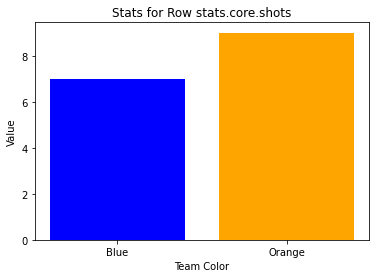

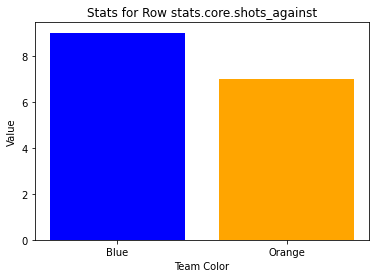

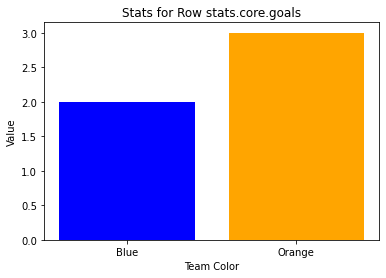

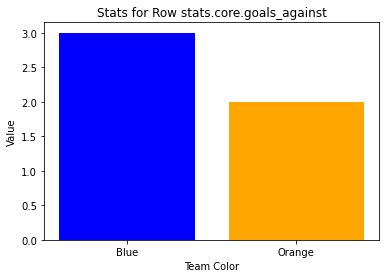

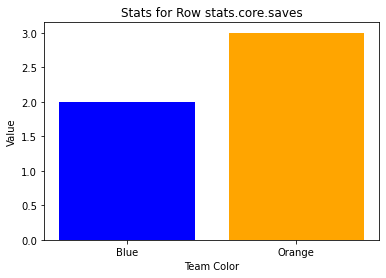

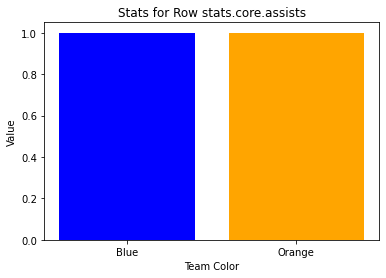

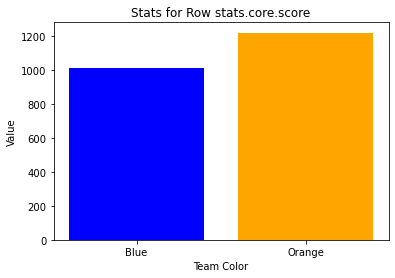

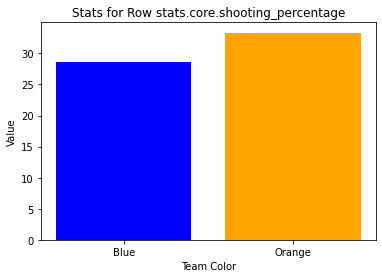

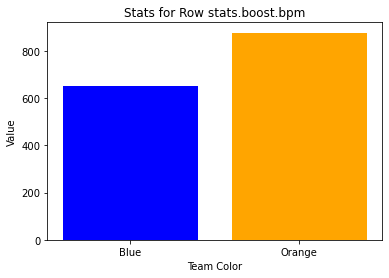

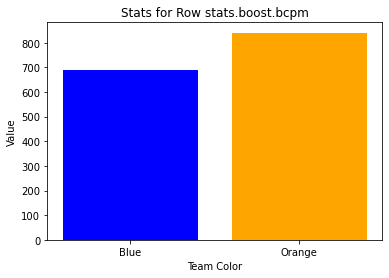

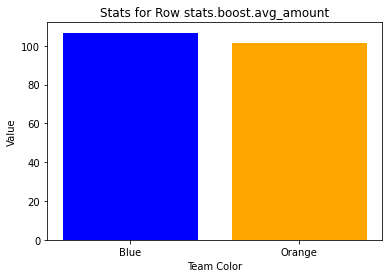

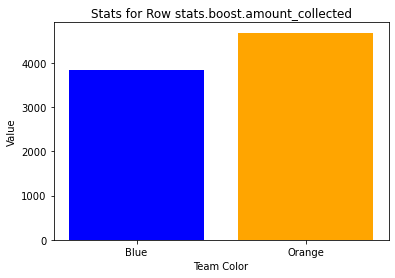

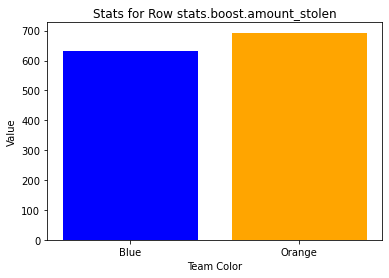

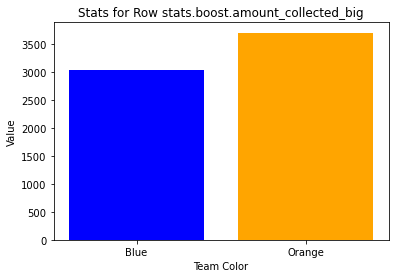

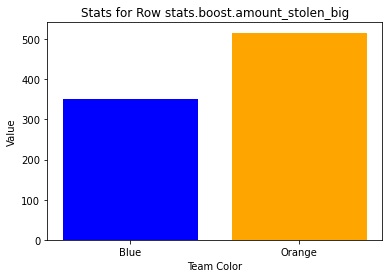

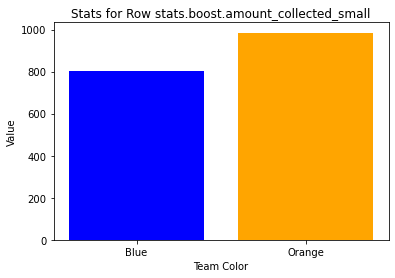

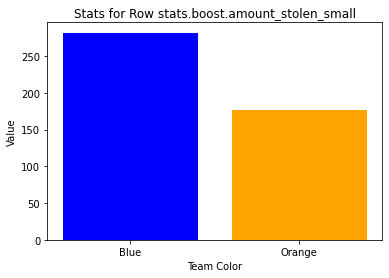

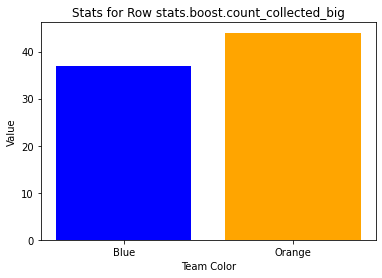

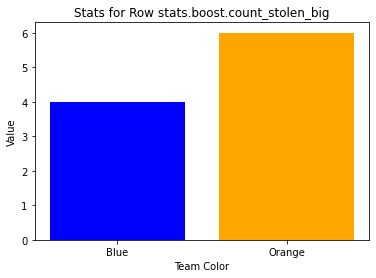

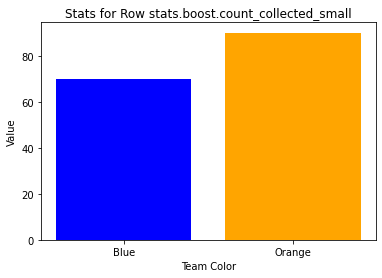

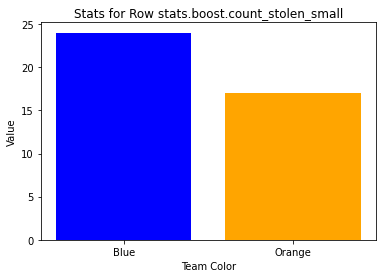

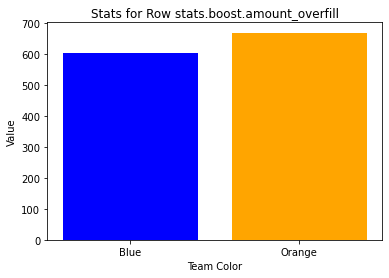

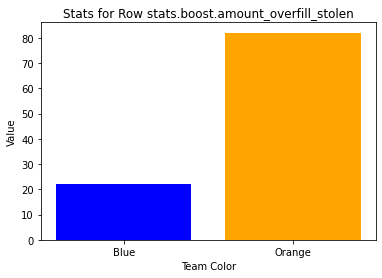

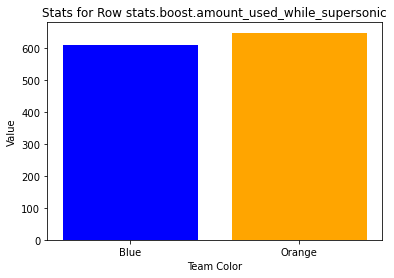

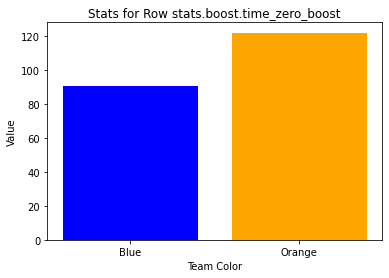

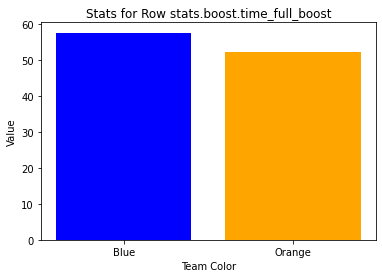

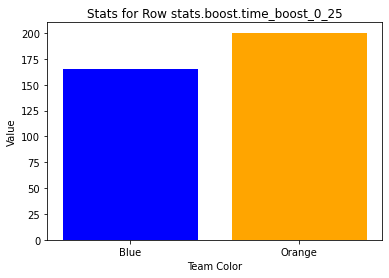

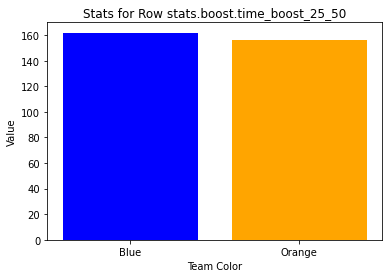

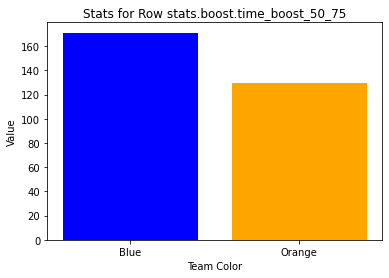

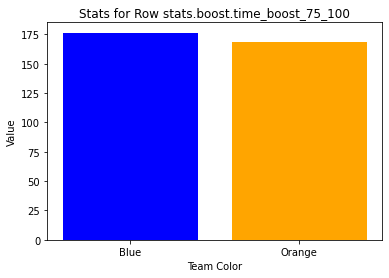

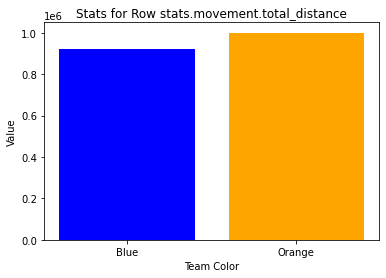

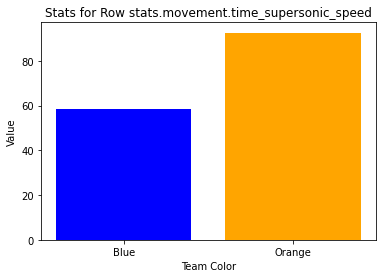

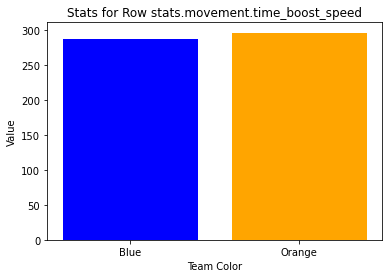

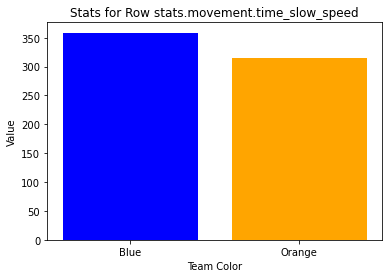

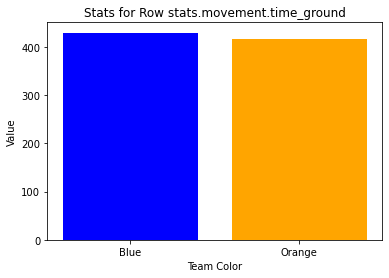

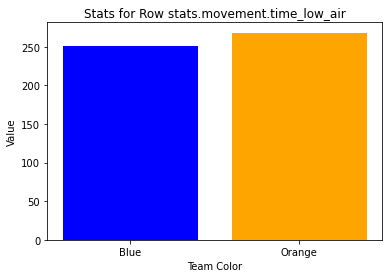

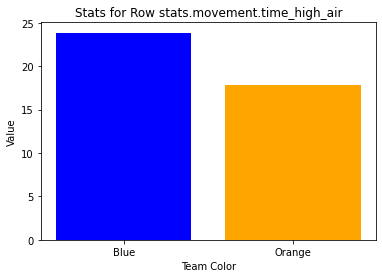

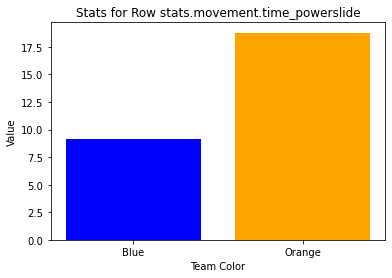

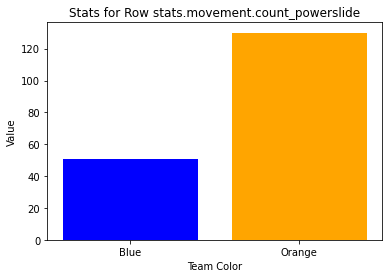

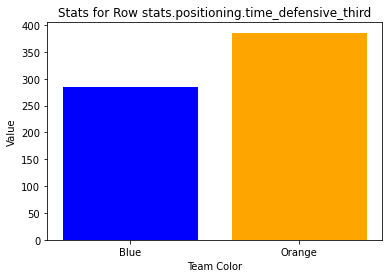

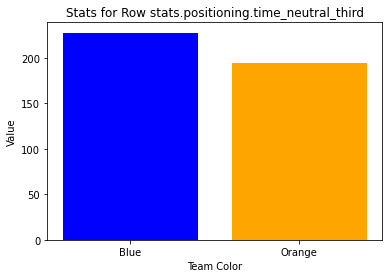

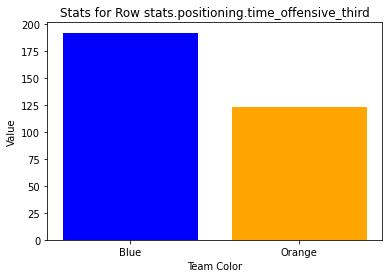

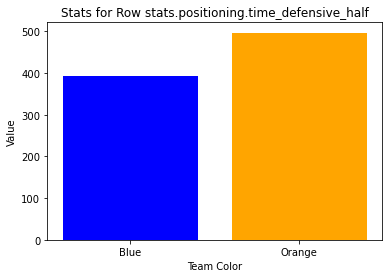

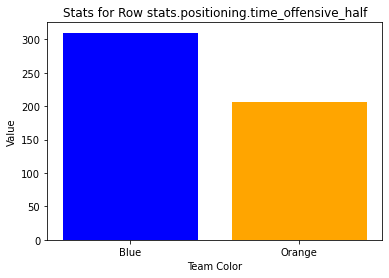

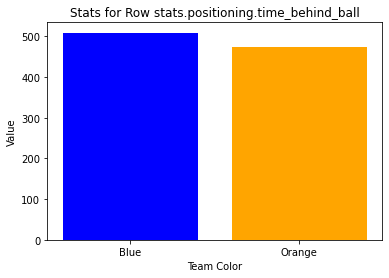

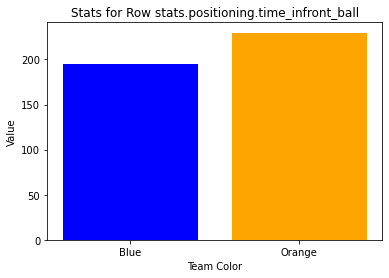

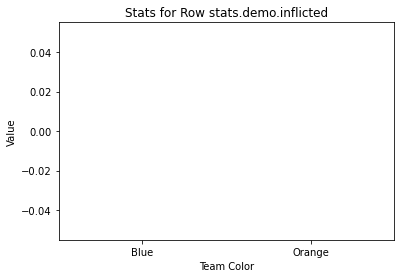

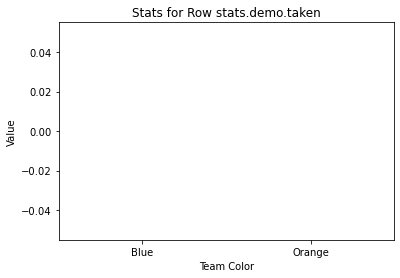

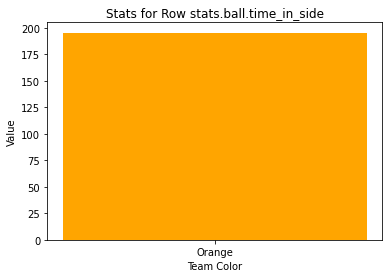

The barcharts provided are simply a visual of the team stats of the first row
                                               blue      orange
color                                          blue      orange
stats.core.shots                                  7           9
stats.core.shots_against                          9           7
stats.core.goals                                  2           3
stats.core.goals_against                          3           2
stats.core.saves                                  2           3
stats.core.assists                                1           1
stats.core.score                               1010        1220
stats.core.shooting_percentage            28.571428   33.333332
stats.boost.bpm                                 651         878
stats.boost.bcpm                           689.0304    840.4341
stats.boost.avg_amount                       106.72      101.26
stats.boost.amount_collected                   3841        4685
stats.boost.amount_stolen 

In [349]:
# Apply the written "create_barcharts()" function
game1 = combined_list[0].iloc[1:, 0:2]
create_barcharts(game1)

print("The barcharts provided are simply a visual of the team stats of the first row")
print(combined_list[0]) 


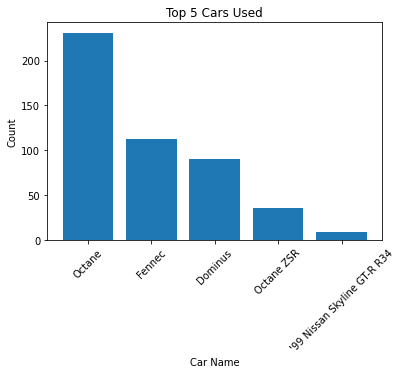

In Rocket League, the car used has no effect on the car's stats (e.g. speed, acceleration, etc.)There are slight differences in the size of the car's 'Hitbox'. Which is the geometrical surfaces that make up the car's length, wight, and height that interact with the ball.


In [341]:
# Count the occurrences of each car name
car_counts = all_players_df['car_name'].value_counts().head(5)

# Create a bar chart
plt.bar(car_counts.index, car_counts.values)

# Add labels and title
plt.xlabel('Car Name')
plt.ylabel('Count')
plt.title('Top 5 Cars Used')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the chart
plt.show()

print("In Rocket League, the car used has no effect on the car's stats (e.g. speed, acceleration, etc.)"
      "There are slight differences in the size of the car's 'Hitbox'. Which is the geometrical "
     "surfaces that make up the car's length, wight, and height that interact with the ball.")

### Data Splitting

In [346]:
from sklearn.model_selection import train_test_split

# Split the data for model construction purposes
train_data, test_data = train_test_split(all_players_df, test_size=0.3, random_state=42)

# Display the sizes of the resulting train and test data
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))


Train data size: 380
Test data size: 163


In [347]:
# Save train_data as CSV
train_data.to_csv('train_data.csv', index=False)

# Save test_data as CSV
test_data.to_csv('test_data.csv', index=False)


## ---------Model Building and Evaluation---------

In [478]:
# Load in the data
train = pd.read_csv("train_data.csv")

test = pd.read_csv("test_data.csv")


### Model Building

In [479]:
# Check training data for any null values
null_values = train.isnull().sum()
print("Null values:\n", null_values)
print()

# Check for None values
none_values = train.isin([None]).sum()
print("None values:\n", none_values)


Null values:
 start_time                             0
end_time                               0
name                                   0
car_id                                 0
car_name                              10
shots                                  0
shots_against                          0
goals                                  0
goals_against                          0
saves                                  0
assists                                0
score                                  0
avg_distance_to_ball                   0
avg_distance_to_ball_possession        0
avg_distance_to_ball_no_possession     0
avg_distance_to_mates                  0
time_defensive_third                   0
time_neutral_third                     0
time_offensive_third                   0
time_defensive_half                    0
time_offensive_half                    0
time_behind_ball                       0
time_infront_ball                      0
time_most_back                         0
ti

In [480]:
# Remove rows with null values
train = train.dropna()

# Verify the resulting DataFrame
print(train.shape)
print(train.head())


(370, 40)
   start_time   end_time           name  car_id    car_name  shots  \
0           0  301.90600  [huiTre] tMd^    1568  Octane ZSR      5   
1           0  348.77695       Tripz_Oh      23      Octane      3   
2           0  355.46765           Plum    4284      Fennec      2   
3           0  453.37590        Typical      23      Octane      6   
4           0  333.39800         keatoa      23      Octane      1   

   shots_against  goals  goals_against  saves  ...  percent_neutral_third  \
0              5      3              2      0  ...              23.674406   
1              4      0              1      1  ...              29.833294   
2              4      1              2      1  ...              37.794320   
3              8      2              2      1  ...              29.425539   
4              5      1              1      4  ...              37.978710   

   percent_defensive_half  percent_offensive_half  percent_behind_ball  \
0               66.076775       

In [481]:
X = all_players_df[
    ['shots', 'shots_against', 'goals', 'goals_against', 'saves', 'assists', 
     'score', 'avg_distance_to_ball', 'avg_distance_to_ball_possession', 
     'avg_distance_to_ball_no_possession', 'avg_distance_to_mates',
    'time_defensive_third', 'time_neutral_third', 'time_offensive_third', 
     'time_defensive_half', 'time_offensive_half', 'time_behind_ball', 
     'time_infront_ball', 'time_most_back', 'time_most_forward',
    'goals_against_while_last_defender', 'time_closest_to_ball', 
     'time_farthest_from_ball', 'percent_defensive_third', 
     'percent_offensive_third', 'percent_neutral_third', 
     'percent_defensive_half', 'percent_offensive_half', 'percent_behind_ball', 
     'percent_infront_ball', 'percent_most_back', 'percent_most_forward', 
     'percent_closest_to_ball', 'percent_farthest_from_ball']
]

y = all_players_df['mvp']


In [482]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_encoded = label_encoder.fit_transform(y)


### Model Selection and Optimization
Logistic Classification was chosen was for the following reasons
1. Interpretability
2. Potential linear relationships
3. Binary Classification
4. Small dataset (i.e doesn't require a lot of predictors)


#### Check Assumption of Linearity Between Features and Predictor

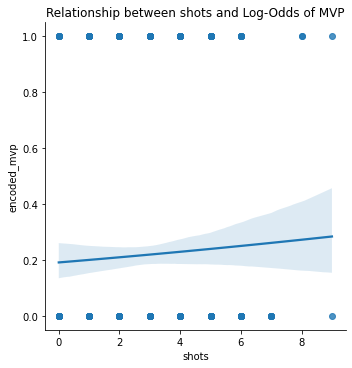

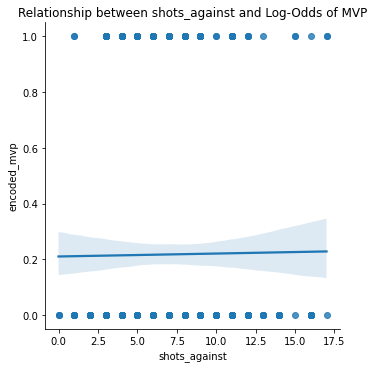

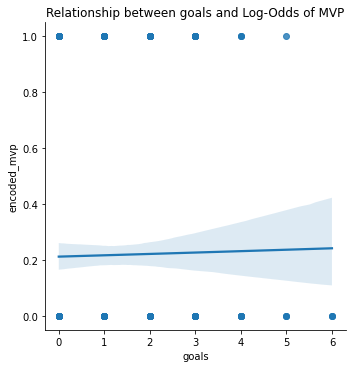

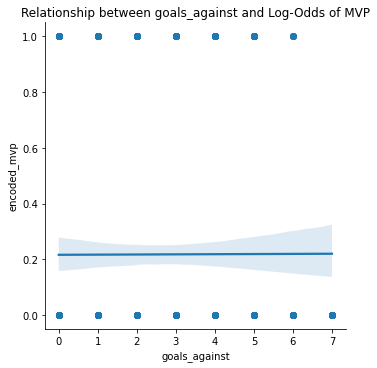

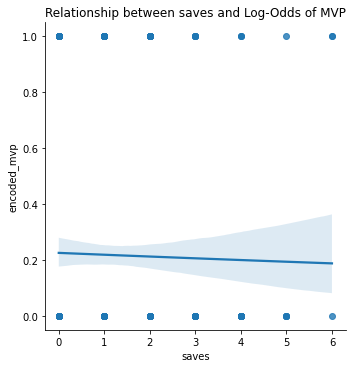

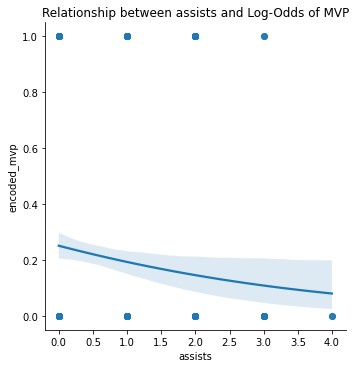

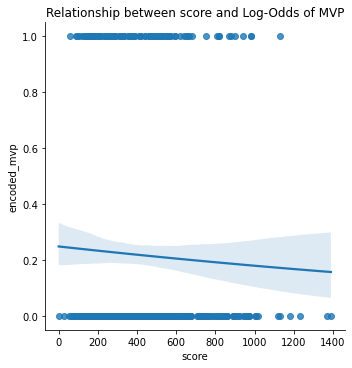

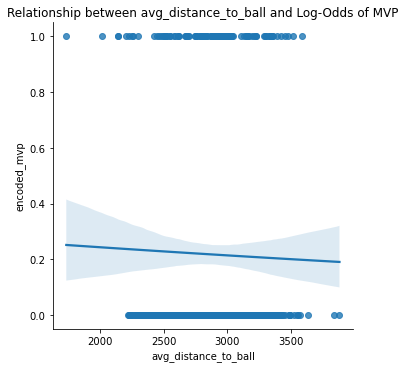

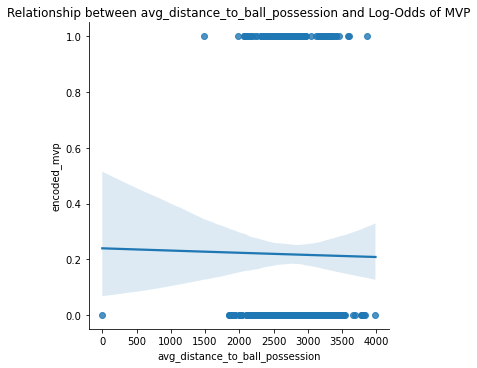

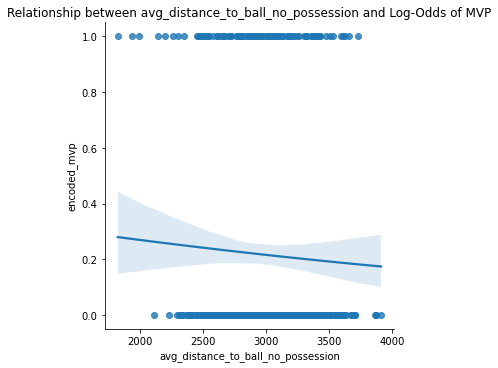

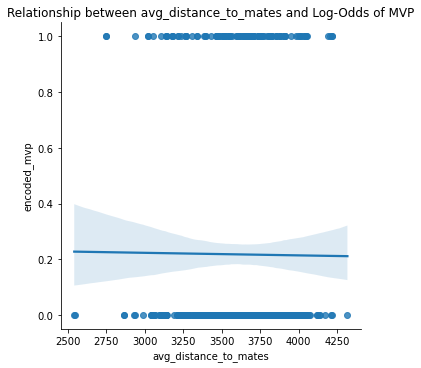

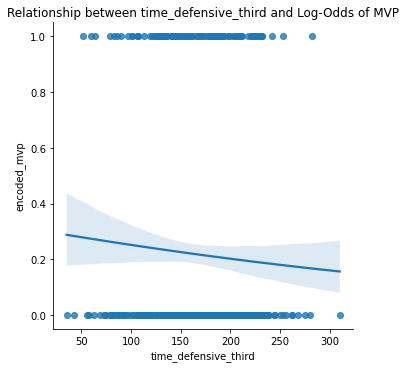

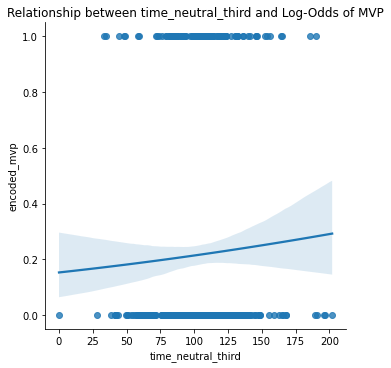

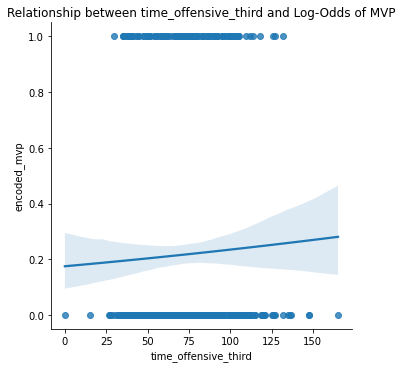

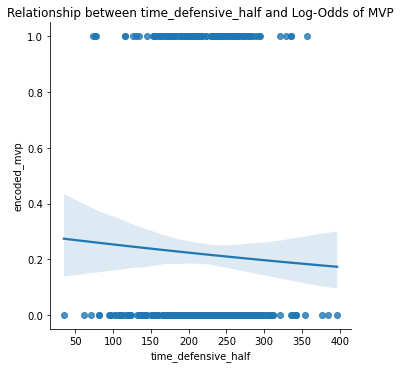

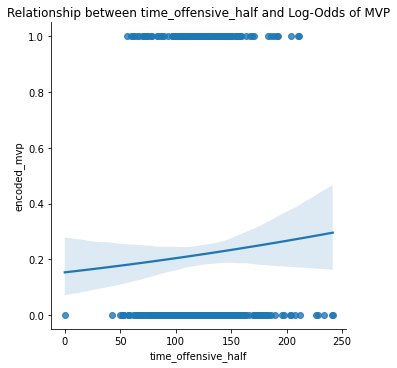

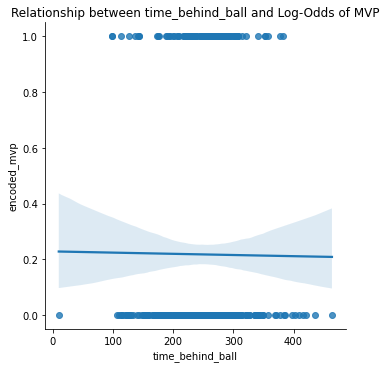

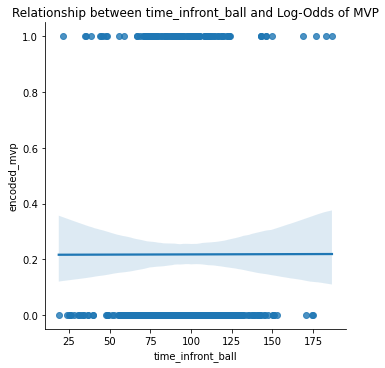

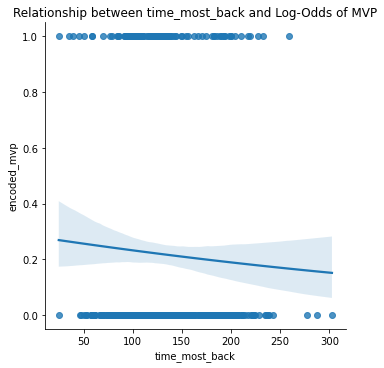

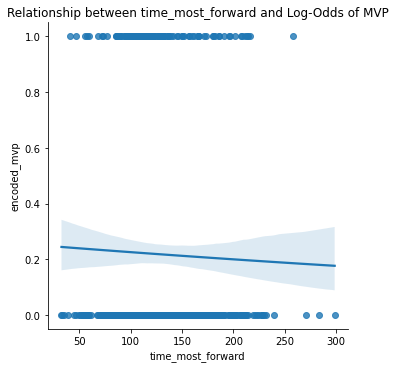

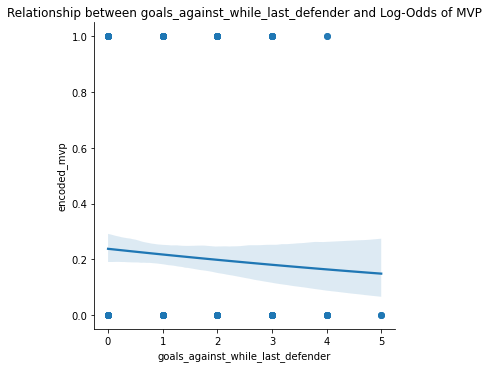

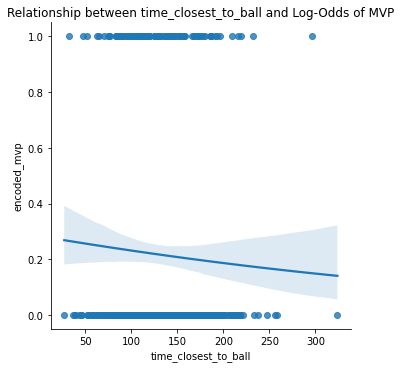

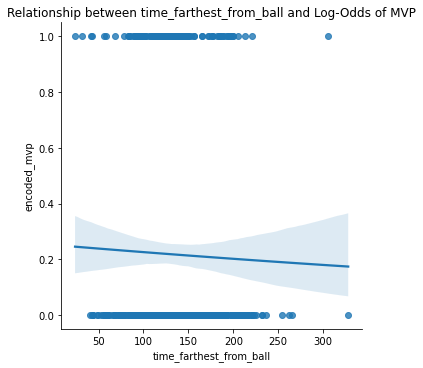

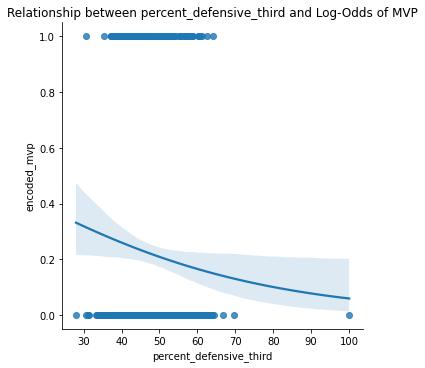

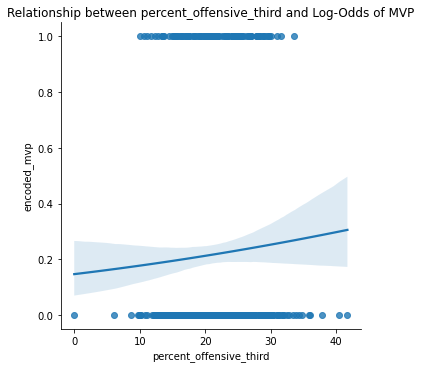

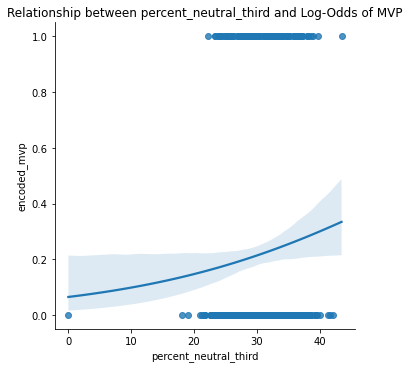

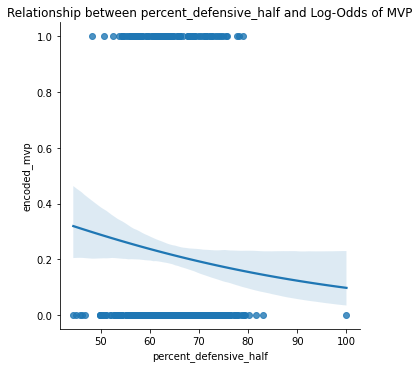

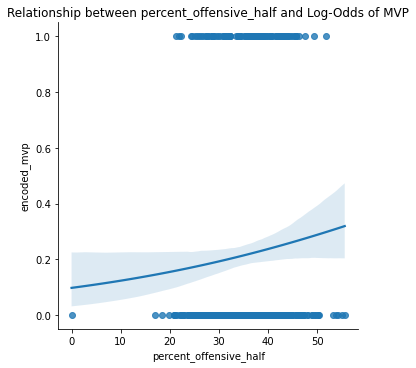

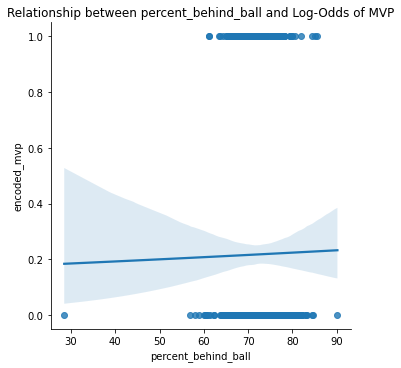

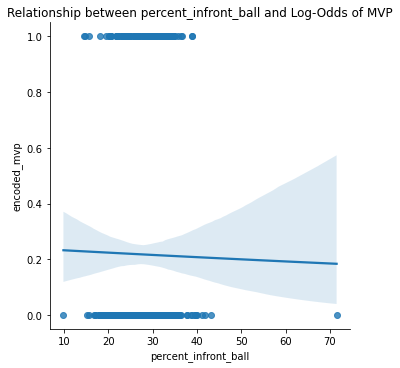

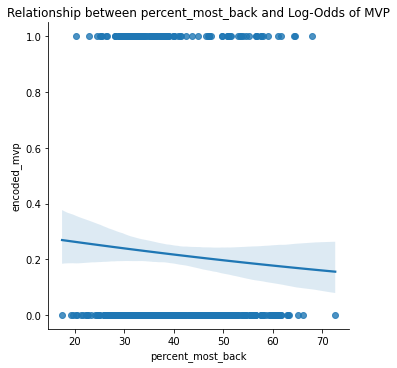

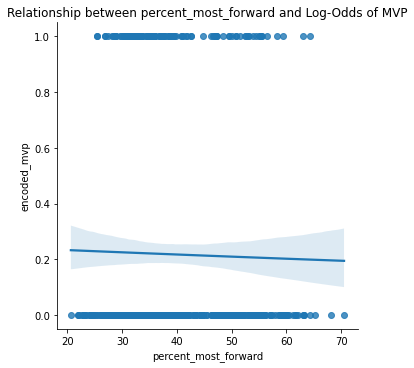

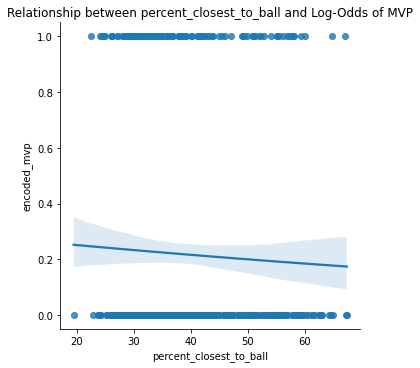

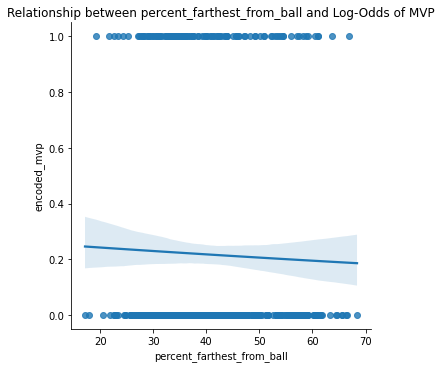

In [483]:
import seaborn as sns

# Concatenate X and y_encoded into a single DataFrame
data = pd.concat([X, pd.Series(y_encoded, name='encoded_mvp')], axis=1)

# Iterate over each independent variable
for column in X.columns:
    # create a scatter plot with a logistic regression line
    sns.lmplot(x=column, y='encoded_mvp', data=data, logistic=True, height=5)
    plt.title(f"Relationship between {column} and Log-Odds of MVP")
    plt.show()


#### Check Assumption Independence of Observations

time_behind_ball and time_defensive_half are highly correlated.
percent_closest_to_ball and percent_most_forward are highly correlated.
percent_farthest_from_ball and percent_most_back are highly correlated.
percent_offensive_half and percent_defensive_third are highly correlated.
percent_defensive_half and percent_defensive_third are highly correlated.
time_defensive_half and time_defensive_third are highly correlated.
time_farthest_from_ball and time_most_back are highly correlated.
percent_infront_ball and percent_behind_ball are highly correlated.
avg_distance_to_ball_no_possession and avg_distance_to_ball are highly correlated.
avg_distance_to_ball_possession and avg_distance_to_ball are highly correlated.
time_closest_to_ball and time_most_forward are highly correlated.
percent_defensive_half and percent_offensive_third are highly correlated.
percent_offensive_half and percent_defensive_half are highly correlated.
percent_offensive_half and percent_offensive_third are highly corr

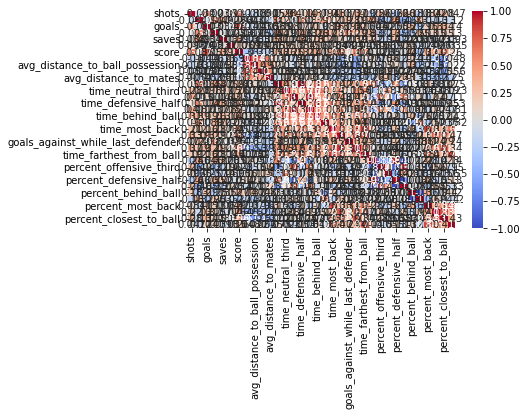

In [370]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Set the threshold for correlation
threshold = 0.8

# Print the highly correlated columns
highly_correlated_cols = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            highly_correlated_cols.add((col1, col2))

# Print the highly correlated columns
for col1, col2 in highly_correlated_cols:
    print(f"{col1} and {col2} are highly correlated.")

# Add a space between print statements
print()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Show the plot
plt.show()


#### Check Assumption of MultiColinearity Between Independent Variables

In [385]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remove null and None values from X
X_cleaned = X.dropna()

# Create a DataFrame with the independent variables
independent_variables = X_cleaned

# Calculate the VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = independent_variables.columns
vif["VIF"] = [variance_inflation_factor(independent_variables.values, i) for i in range(independent_variables.shape[1])]

# Filter variables with VIF greater than or equal to 5
high_vif_variables = vif[vif["VIF"] >= 5]

# Filter variables with VIF less than 5
low_vif_variables = vif[vif["VIF"] < 5]

# Print the variables with high VIF
print("Variables with VIF greater than or equal to 5:")
print(high_vif_variables)

# Print the variables with low VIF
print("Variables with VIF less than 5:")
print(low_vif_variables)


Variables with VIF greater than or equal to 5:
                              Variable           VIF
0                                shots  8.089606e+00
1                        shots_against  1.847823e+01
2                                goals  1.575083e+01
3                        goals_against  1.068309e+01
4                                saves  6.339437e+00
6                                score  7.102476e+01
7                 avg_distance_to_ball  7.077370e+03
8      avg_distance_to_ball_possession  1.605322e+03
9   avg_distance_to_ball_no_possession  1.846312e+03
10               avg_distance_to_mates  5.597872e+02
11                time_defensive_third  8.594755e+08
12                  time_neutral_third  3.304710e+08
13                time_offensive_third  1.653843e+08
14                 time_defensive_half  5.160922e+07
15                 time_offensive_half  1.569185e+07
16                    time_behind_ball  1.877475e+09
17                   time_infront_ball  2.855166e+08

#### Train the model with the training data and Feature Selection

In [486]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the logistic regression classifier
logistic_classifier = LogisticRegression()


In [487]:
'''
Given the findings regarding data assumptions for linear classication, we have the following
'''
X_train = train[['assists',  'goals_against_while_last_defender']]
y_train = train['mvp']

print(X_train.shape)
print(y_train.shape)
print()
from sklearn.metrics import accuracy_score

# Fit the model to training data
logistic_classifier.fit(X_train, y_train)

# Train the model
y_pred_train = logistic_classifier.predict(X_train)

# Evaluate the performance of the classifier (e.g., accuracy) on training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy on training set:",accuracy_train)


(370, 2)
(370,)

Accuracy on training set: 0.7756756756756756


In [488]:
X_test = test[['assists',  'goals_against_while_last_defender']]
y_test = test['mvp']

# Fit the model to test data
y_pred_test = logistic_classifier.predict(X_test)

# Evaluate the performance of the classifier (e.g., accuracy) on test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set:",accuracy_test)


Accuracy on test set: 0.7975460122699386


#### Hyperparameter tuning

In [430]:
from sklearn.model_selection import GridSearchCV

# Create an instance of the logistic regression classifier
logistic_classifier = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(logistic_classifier, param_grid, cv=5)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Fit the best model to the training data
best_model.fit(X_train, y_train)

# Predict on the training and test data using the best model
y_pred_train_optimum = best_model.predict(X_train)
y_pred_test_optimum = best_model.predict(X_test)

# Evaluate the performance of the best model
accuracy_train_optimum = accuracy_score(y_train, y_pred_train_optimum)
accuracy_test_optimum = accuracy_score(y_test, y_pred_test_optimum)

print("Best hyperparameters:", best_params)
print("Important Note: Higher weights are assigned tothe feature 'assists' sice it met the logistic classification"
     " assumptions better than the other feature considered")
print()
print("Accuracy on training set w/ optimum parameters:", accuracy_train_optimum)
print("Accuracy on test set w/ optimum parameters:", accuracy_test_optimum)


C:\Users\andio\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'}
Important Note: Higher weights are assigned tothe feature 'assists' sice it met the logistic classification assumptions better than the other feature considered

Accuracy on training set w/ optimum parameters: 0.7756756756756756
Accuracy on test set w/ optimum parameters: 0.7975460122699386


#### Random Forest Model

In [496]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the Random Forest Classifier
random_forest_classifier = RandomForestClassifier()

# Fit the model to the training data
random_forest_classifier.fit(X_train, y_train)

# Predict on the training data
y_pred_train = random_forest_classifier.predict(X_train)

# Evaluate the performance on the training set
accuracy_train3 = accuracy_score(y_train, y_pred_train)
print("Accuracy on training set:", accuracy_train3)

# Predict on the testing data
y_pred_test = random_forest_classifier.predict(X_test)

# Evaluate the performance on the testing set
accuracy_test3 = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set:", accuracy_test3)


Accuracy on training set: 0.7756756756756756
Accuracy on test set: 0.7975460122699386


In [498]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(random_forest_classifier, param_grid, cv=5)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the model
best_model.fit(X_train, y_train)

# Predict on the training and test data using the best model
y_pred_train_optimum = best_model.predict(X_train)
y_pred_test_optimum = best_model.predict(X_test)

# Evaluate the performance of the best model
accuracy_train_optimum2 = accuracy_score(y_train, y_pred_train_optimum)
accuracy_test_optimum2 = accuracy_score(y_test, y_pred_test_optimum)

print("Best hyperparameters:", best_params)
print()
print("Accuracy on training set w/ optimum parameters:", accuracy_train_optimum2)
print("Accuracy on test set w/ optimum parameters:", accuracy_test_optimum2)
print("In this case, the adjusted hyperparameters have actually caused the model to perform worse"
     " than when using the default parameters.")


Best hyperparameters: {'class_weight': {0: 1, 1: 3}, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Accuracy on training set w/ optimum parameters: 0.6459459459459459
Accuracy on test set w/ optimum parameters: 0.5398773006134969
In this case, the adjusted hyperparameters have actually caused the model to perform worse than when using the default parameters.


#### Decision Tree Model

In [491]:
from sklearn.tree import DecisionTreeClassifier

# Create an instance of the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier()

# Fit the model
decision_tree_classifier.fit(X_train, y_train)

# Predict on the training data
y_pred_train = decision_tree_classifier.predict(X_train)

# Evaluate the performance
accuracy_train2 = accuracy_score(y_train, y_pred_train)
print("Accuracy on training set:", accuracy_train2)
print()

# Predict on the testing data
y_pred_test = decision_tree_classifier.predict(X_test)
accuracy_test2 = accuracy_score(y_test, y_pred_test)

print("Accuracy on test set:", accuracy_test2)


Accuracy on training set: 0.7756756756756756

Accuracy on test set: 0.7975460122699386


In [493]:
# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 5}]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(decision_tree_classifier, param_grid, cv=5)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Fit the best model to the training data
best_model.fit(X_train, y_train)

# Predict on the training and test data using the best model
y_pred_train_optimum = best_model.predict(X_train)
y_pred_test_optimum = best_model.predict(X_test)

# Evaluate the performance of the best model
accuracy_train_optimum3 = accuracy_score(y_train, y_pred_train_optimum)
accuracy_test_optimum3 = accuracy_score(y_test, y_pred_test_optimum)

print("Best hyperparameters:", best_params)
print()
print("Accuracy on training set w/ optimum parameters:", accuracy_train_optimum3)
print("Accuracy on test set w/ optimum parameters:", accuracy_test_optimum3)
print("Even after adjusting parameters to account for overfitting, the model did not perform any better"
     " than the same model using default parameters.")


Best hyperparameters: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy on training set w/ optimum parameters: 0.7756756756756756
Accuracy on test set w/ optimum parameters: 0.7975460122699386
Even after adjusting parameters to account for overfitting, the model did not perform any better than the same model using default parameters.


### Model Evaluation 

In [528]:
print("---Logistic Classifier Accuracy w/ default parameters---")
print("Accuracy on training set:",accuracy_train)
print("Accuracy on test set:",accuracy_test)
print()

print("---Logistic Classifier Accuracy w/ optimum parameters---")
print("Accuracy on training set w/ optimum parameters:", accuracy_train_optimum)
print("Accuracy on test set w/ optimum parameters:", accuracy_test_optimum)
print()

print("---Random Forest Classifier Accuracy w/ optimum parameters---")
print("Accuracy on training set w/ optimum parameters:", accuracy_train_optimum2)
print("Accuracy on test set w/ optimum parameters:", accuracy_test_optimum2)
print()

print("---Decision Tree Accuracy w/ default parameters---")
print("Accuracy on training set:",accuracy_train)
print("Accuracy on test set:",accuracy_test)
print()

print("---Decision Tree Accuracy w/ optimum parameters---")
print("Accuracy on training set w/ optimum parameters:", accuracy_train_optimum3)
print("Accuracy on test set w/ optimum parameters:", accuracy_test_optimum3)


---Logistic Classifier Accuracy w/ default parameters---
Accuracy on training set: 0.7756756756756756
Accuracy on test set: 0.7975460122699386

---Logistic Classifier Accuracy w/ optimum parameters---
Accuracy on training set w/ optimum parameters: 0.9945945945945946
Accuracy on test set w/ optimum parameters: 0.8679245283018868

---Random Forest Classifier Accuracy w/ optimum parameters---
Accuracy on training set w/ optimum parameters: 0.6459459459459459
Accuracy on test set w/ optimum parameters: 0.5398773006134969

---Decision Tree Accuracy w/ default parameters---
Accuracy on training set: 0.7756756756756756
Accuracy on test set: 0.7975460122699386

---Decision Tree Accuracy w/ optimum parameters---
Accuracy on training set w/ optimum parameters: 0.7756756756756756
Accuracy on test set w/ optimum parameters: 0.7975460122699386


### Calculating Game Score and predicting MVP

In [527]:
# Calculate the game_performance score for all unique players
all_players_df['game_performance'] = 0.9 * all_players_df['assists'] + 0.1 * all_players_df['goals_against_while_last_defender']

# Predict the MVP based on the game_performance score
all_players_df['predicted_mvp'] = all_players_df['game_performance'] > 0.5

# Convert predicted_mvp to 1 (True) or 0 (False)
all_players_df['predicted_mvp'] = all_players_df['predicted_mvp'].astype(int)

# Compare the predicted MVP with the actual MVP values
accuracy = accuracy_score(all_players_df['mvp'], all_players_df['predicted_mvp'])
print("Accuracy:", accuracy)

print()
print("Based on the written game_performance score equation, a little more than 50% of the"
     "predictions were right when compared to the test data. During model building I placed a greater"
     "weight on the feature 'assists', baecuase it demonstrated to have the best combination of a "
     "linear relationship and lack of multicollinearity.")

Accuracy: 0.5414364640883977

Based on the written game_performance score equation, a little more than 50% of thepredictions were right when compared to the test data. During model building I placed a greaterweight on the feature 'assists', baecuase it demonstrated to have the best combination of a linear relationship and lack of multicollinearity.


## ---------References---------

### Image

1. Nickolas Carroll, (2021, March 17), How to Watch Rocket League, esports.missouri.edu. 
https://esports.missouri.edu/how-to-watch-rocket-league/


2. lethamyr.com, (n.d.) Top Down Rocket League, lethamyr.com. 
https://lethamyr.com/mymaps/top-down-rocket-league


### Online

3. Ballchasing.(n.d.). Ballchasing.com. Retrieved  May 20, 2023, from https://ballchasing.com 


4. Ballchasing.(n.d.). API Documentation. Ballchasing.com. Retrieved  May 20, 2023, from https://ballchasing.com/doc/api 


5. Ballchasing.(n.d.). Frequently Asked Questions (FAQ). Ballchasing.com. Retrieved  May 20, 2023, from https://ballchasing.com/doc/faq 


6. Hockey-Graphs. (2016, July 13). Measuring Single-Game Productivity: An introduction to Game Score. Hockey-Graphs. Retrieved  May 20, 2023, from https://hockey-graphs.com/2016/07/13/measuring-single-game-productivity-an-introduction-to-game-score/

### Course

7.  Dalton. (2023). Data Science Tools II [COMP4448]. University of Denver.


